In [2]:
!curl -L -o dataset.h5ad https://datasets.cellxgene.cziscience.com/5f462e5e-0e6e-45ff-84e5-d18fea2ee7d6.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:08 --:--:--     0
  0     0    0     0    0     0      0      0 --:--

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import partipy as pt


# Verbosity parameter shows amount of
# logging you will see during functions' execution
sc.settings.verbosity = 3

# Reading of the dataset

adata = sc.read_h5ad("dataset.h5ad")
adata


AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'Time', 'donor_time', 'leiden', 'sample', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n.cells', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [2]:
X = adata.X

X = X.toarray()

print("Shape:", X.shape)
print("Mean:", X.mean())
print("Median:", np.median(X))
print("Std:", X.std())
print("Min:", X.min())
print("Max:", X.max())


Shape: (57019, 24349)
Mean: 0.2281979
Median: 0.0
Std: 6.083767
Min: 0.0
Max: 21618.004


In [3]:
obs_keep = [
    "donor_id",
    "sample",
    "tissue",
    "tissue_type",
    "cell_type",
    "author_cell_type",
    "sex",
    "development_stage",
    "disease",
    "Time",
    "donor_time"
]

var_keep = [
    "gene_symbols",
    "feature_name",
    "feature_biotype",
    "feature_length"
]

obs_keep = [c for c in obs_keep if c in adata.obs.columns]

obs = adata.obs[obs_keep].copy()

var_keep = [c for c in var_keep if c in adata.var.columns]

var = adata.var[var_keep].copy()

adata_new = AnnData(
    X=adata.X,   # лучше использовать исходное adata.X
    obs=obs,
    var=var
)


adata_new



AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'sample', 'tissue', 'tissue_type', 'cell_type', 'author_cell_type', 'sex', 'development_stage', 'disease', 'Time', 'donor_time'
    var: 'gene_symbols', 'feature_name', 'feature_biotype', 'feature_length'

In [4]:
# создаём словарь ENSG -> gene_symbol
gene_map = (
    adata_new.var
    .reset_index()
    .set_index("index")["gene_symbols"]
    .dropna()
    .to_dict()
)

# заменяем имена в индексе var
adata_new.var.index = adata_new.var.index.to_series().replace(gene_map)

adata_new.var


gene_symbols     feature_name feature_biotype feature_length
RP11-34P13.8  RP11-34P13.8  ENSG00000239945            gene           1319
FO538757.3      FO538757.3         DDX11L17            gene            570
FO538757.2      FO538757.2           WASH9P            gene           1397
AP006222.2      AP006222.2  ENSG00000228463            gene            457
RP4-669L17.2  RP4-669L17.2  ENSG00000236601            gene            620
...                    ...              ...             ...            ...
AL354822.1      AL354822.1  ENSG00000278384            gene           3027
AC004556.1      AC004556.1  ENSG00000276345            gene            740
AC233755.2      AC233755.2  ENSG00000277856            gene            294
AC233755.1      AC233755.1  ENSG00000275063            gene            351
AC240274.1      AC240274.1  ENSG00000271254            gene           2922

[24349 rows x 4 columns]

In [5]:
adata_new.var["mt"] = adata_new.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata_new,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)
adata_new.obs["pct_counts_mt"].describe()

count    57019.000000
mean         3.892969
std          2.125316
min          0.000000
25%          2.323794
50%          3.327922
75%          5.066912
max         10.382514
Name: pct_counts_mt, dtype: float64

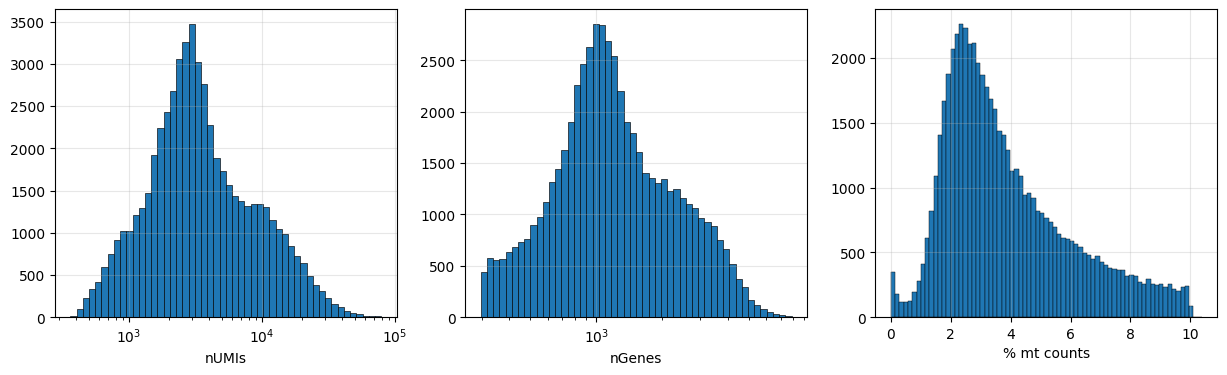

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

sns.histplot(adata_new.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_new.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_new.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

In [7]:
adata_clear = adata_new[
    (adata_new.obs["total_counts"] > 500) &
    (adata_new.obs["total_counts"] < 40000) &
    (adata_new.obs["n_genes_by_counts"] < 6000)
].copy()


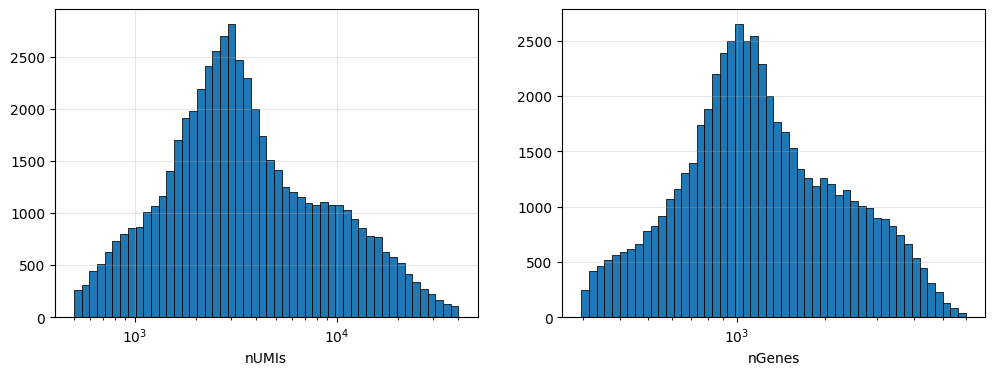

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(adata_clear.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_clear.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

In [9]:
adata_clear.write("adata_raw_clean.h5ad")



In [10]:
print(set(adata_clear.obs["cell_type"]))

{'natural killer cell', 'mast cell', 'plasmacytoid dendritic cell', 'mononuclear leukocyte', 'CD4-positive, alpha-beta T cell', 'B cell', 'lung multiciliated epithelial cell', 'dendritic cell', 'lung macrophage', 'blood vessel endothelial cell', 'muscle cell', 'endothelial cell of lymphatic vessel', 'CD8-positive, alpha-beta cytotoxic T cell', 'plasma cell', 'T cell', 'monocyte', 'pulmonary alveolar epithelial cell', 'regulatory T cell', 'conventional dendritic cell', 'fibroblast'}


In [11]:
immune_cells = [ 'T cell', 'CD8-positive, alpha-beta cytotoxic T cell', 'CD4-positive, alpha-beta T cell', 'B cell', 'regulatory T cell', 'natural killer cell' ]

adata_blood = adata_clear[adata_clear.obs['cell_type'].isin(immune_cells)].copy()

print("Shape:", X.shape)
print("Shape:", adata_blood.shape)

Shape: (57019, 24349)
Shape: (25562, 24349)


In [12]:

adata_blood.raw = adata_blood.copy()
print(adata_blood.n_obs, adata_blood.n_vars)


sc.pp.scrublet(adata_blood, batch_key="donor_id")


25562 24349
Running Scrublet
filtered out 9861 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%
filtered out 7812 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float v

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md



Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 12.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.6%
filtered out 7102 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 6.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%
    Scrublet finished (0:01:31)


In [13]:
sc.pp.filter_genes(adata_blood, min_cells=10)


filtered out 7473 genes that are detected in less than 10 cells


In [14]:
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood)


normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.highly_variable_genes(adata_blood, n_top_genes=3000, batch_key="donor_id")
adata_blood = adata_blood[:, adata_blood.var['highly_variable']]



extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
sc.pp.scale(adata_blood, max_value=10)
sc.pp.pca(adata_blood, n_comps=30)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=30
    finished (0:00:06)


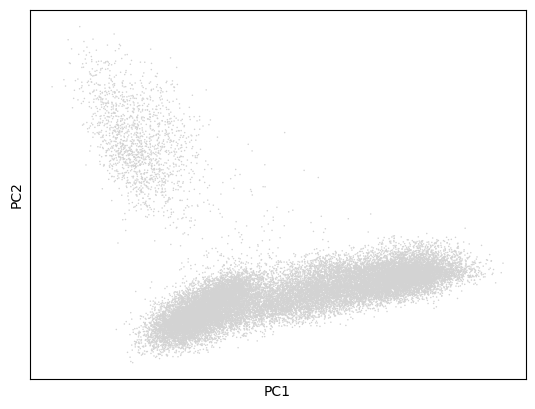

In [17]:
adata_blood.layers["z_scaled"]= sc.pp.scale(adata_blood.X, max_value=10, copy=True)
sc.pl.pca_scatter(adata_blood)

In [18]:
immune_cells = [ 'lung macrophage', 'monocyte', 'T cell', 'CD8-positive, alpha-beta cytotoxic T cell', 'dendritic cell', 'conventional dendritic cell', 'CD4-positive, alpha-beta T cell', 'B cell', 'mast cell', 'regulatory T cell', 'plasmacytoid dendritic cell', 'mononuclear leukocyte', 'plasma cell', 'natural killer cell' ]

adata_blood = adata_clear[adata_clear.obs['cell_type'].isin(immune_cells)].copy()

print("Shape:", X.shape)
print("Shape:", adata_blood.shape)

Shape: (57019, 24349)
Shape: (42422, 24349)


In [19]:

adata_blood.raw = adata_blood.copy()
print(adata_blood.n_obs, adata_blood.n_vars)


sc.pp.scrublet(adata_blood, batch_key="donor_id")


42422 24349
Running Scrublet
filtered out 7462 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
filtered out 5662 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float ve

In [20]:
sc.pp.filter_genes(adata_blood, min_cells=10)


filtered out 5150 genes that are detected in less than 10 cells


In [21]:
sc.pp.normalize_total(adata_blood, target_sum=1e4)
sc.pp.log1p(adata_blood)


normalizing counts per cell
    finished (0:00:00)


In [22]:
sc.pp.highly_variable_genes(adata_blood, n_top_genes=3000, batch_key="donor_id")
adata_blood = adata_blood[:, adata_blood.var['highly_variable']]



extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
sc.pp.scale(adata_blood, max_value=10)
sc.pp.pca(adata_blood, n_comps=30)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=30
    finished (0:00:09)


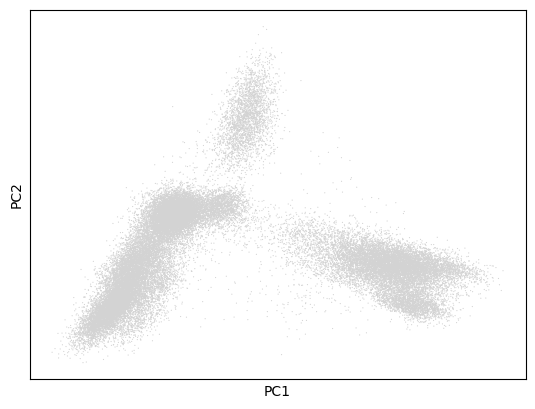

In [24]:
adata_blood.layers["z_scaled"]= sc.pp.scale(adata_blood.X, max_value=10, copy=True)
sc.pl.pca_scatter(adata_blood)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)


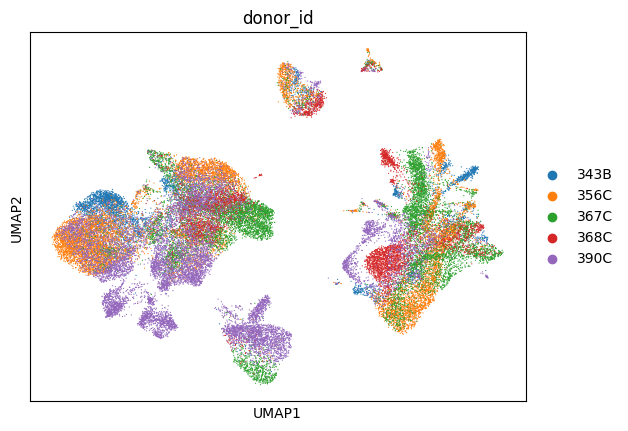

In [25]:
adata_nocorr = adata_blood.copy()

sc.pp.neighbors(adata_nocorr)
sc.tl.umap(adata_nocorr)

sc.pl.umap(adata_nocorr, color="donor_id")



running Leiden clustering


C:\Users\1\AppData\Local\Temp\ipykernel_20024\820519875.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


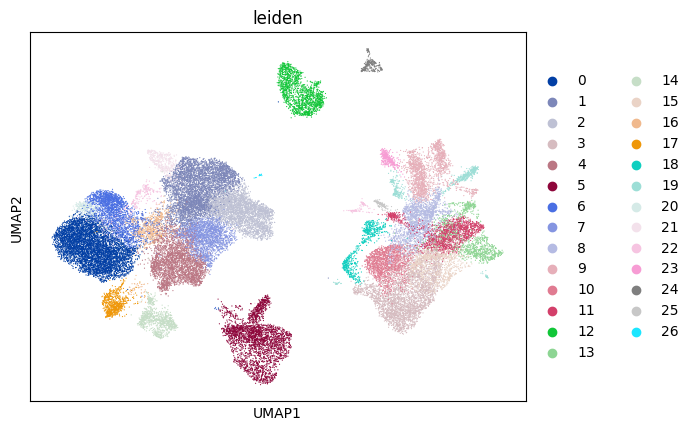

In [26]:
sc.tl.leiden(adata_nocorr)
sc.pl.umap(adata_nocorr, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_20024\2574327039.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


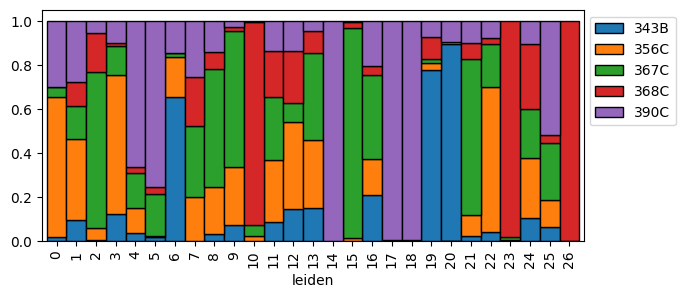

In [27]:
df = adata_nocorr.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

In [28]:
# Harmony
import scanpy.external as sce

adata_harmony = adata_blood.copy()

sce.pp.harmony_integrate(adata_harmony, key="donor_id", max_iter_harmony=30)
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony")
sc.tl.umap(adata_harmony)

2025-12-24 08:34:14,307 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-24 08:34:16,702 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-24 08:34:16,875 - harmonypy - INFO - Iteration 1 of 30
2025-12-24 08:34:26,743 - harmonypy - INFO - Iteration 2 of 30
2025-12-24 08:34:36,624 - harmonypy - INFO - Iteration 3 of 30
2025-12-24 08:34:46,540 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)


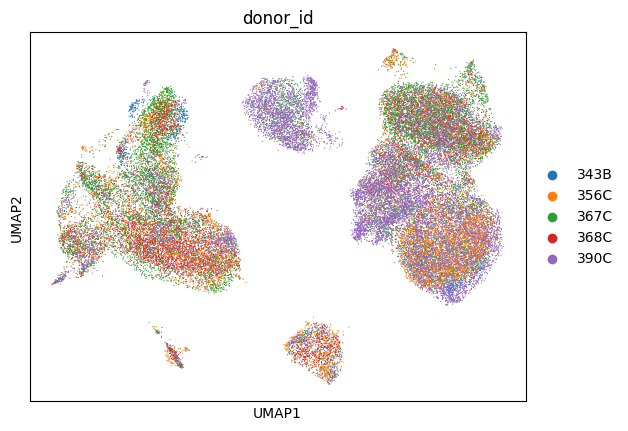

In [29]:
sc.pl.umap(adata_harmony, color="donor_id")

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


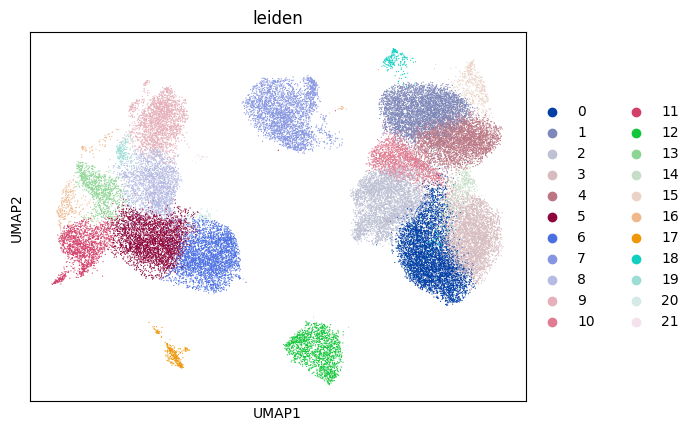

In [30]:
sc.tl.leiden(adata_harmony)
sc.pl.umap(adata_harmony, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_20024\3858766815.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


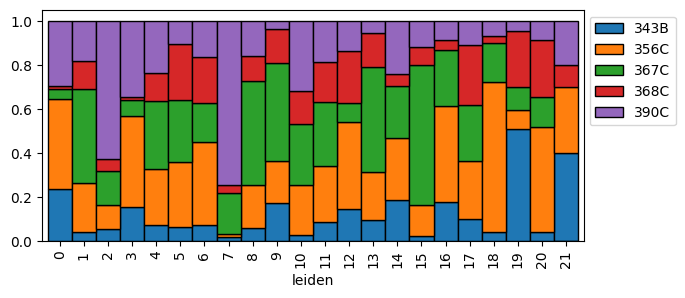

In [31]:
df = adata_harmony.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

ParTIpy

100%|██████████| 50/50 [04:46<00:00,  5.73s/it]


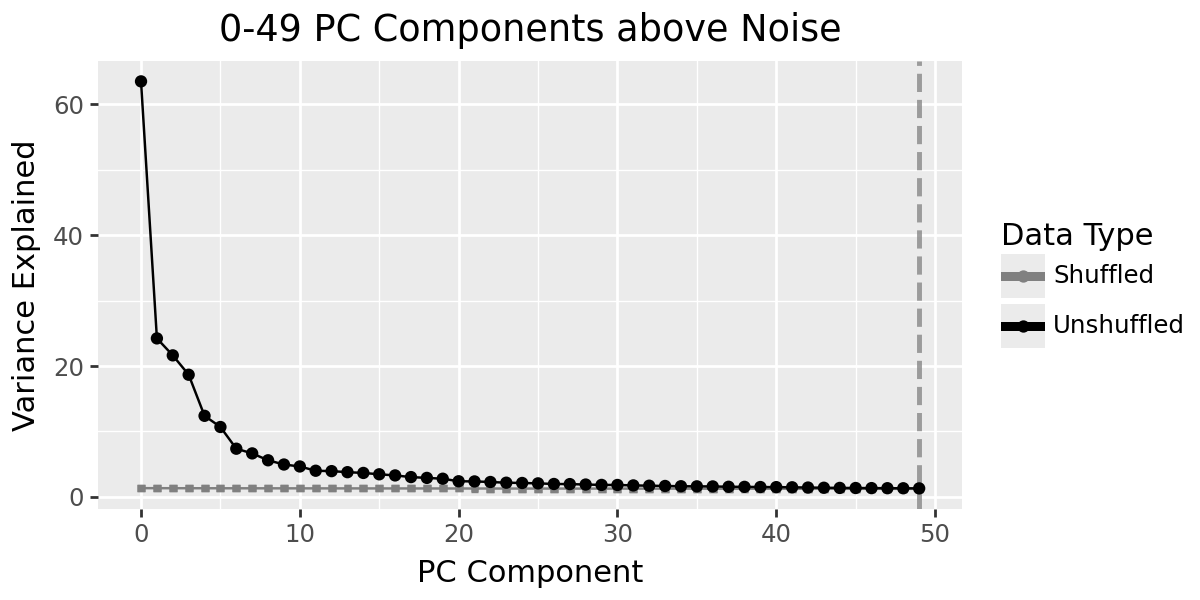

In [33]:
pt.compute_shuffled_pca(adata_harmony)
pt.plot_shuffled_pca(adata_harmony)

In [34]:
pt.set_obsm(adata=adata_harmony, obsm_key="X_pca", n_dimensions=6)

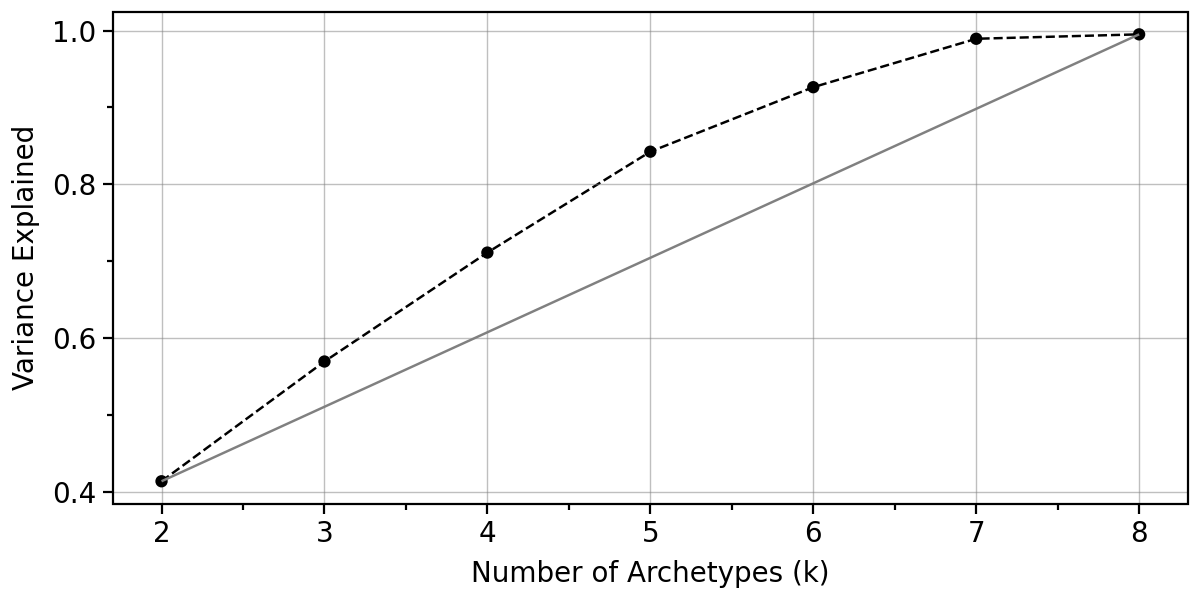

In [35]:
pt.compute_selection_metrics(adata=adata_harmony, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_var_explained(adata_harmony)



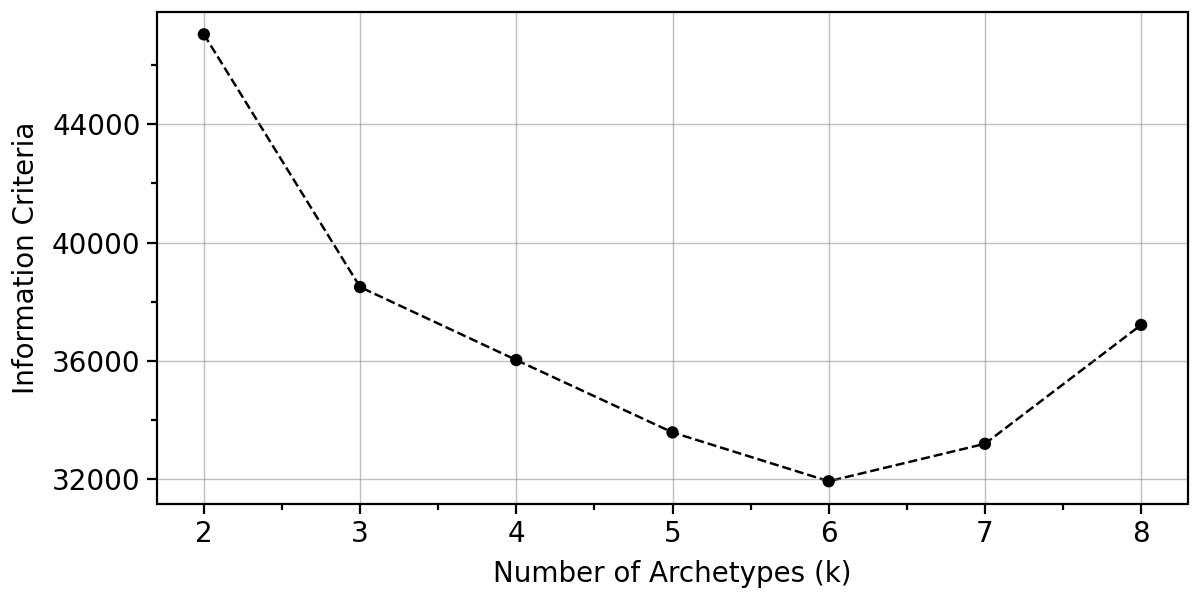

In [36]:
pt.plot_IC(adata_harmony)


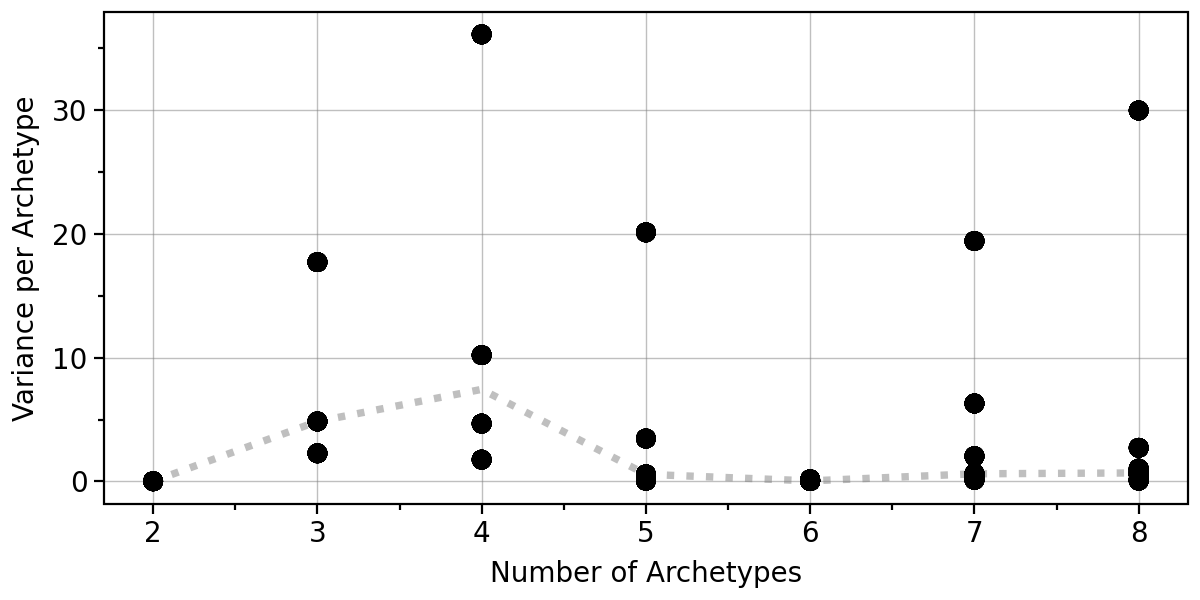

In [37]:
pt.compute_bootstrap_variance(adata=adata_harmony, n_bootstrap=50, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_bootstrap_variance(adata_harmony)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


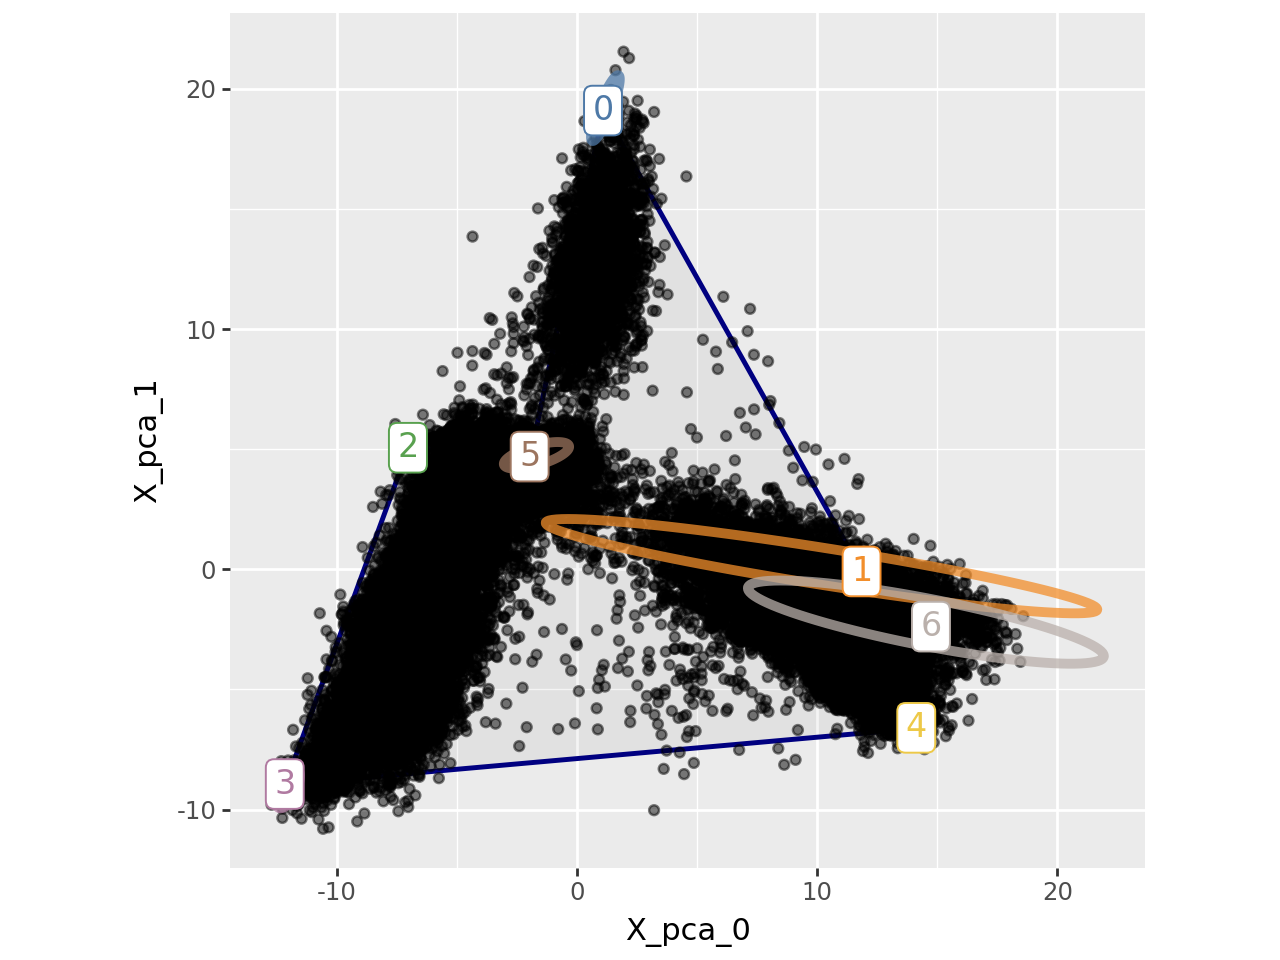

In [38]:
pt.compute_archetypes(adata_harmony, n_archetypes=6, archetypes_only=False, n_jobs=-1)

n_archetypes = 7

pt.plot_archetypes_2D(adata=adata_harmony, show_contours=True, result_filters={"n_archetypes": n_archetypes, "delta": 0.0})

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


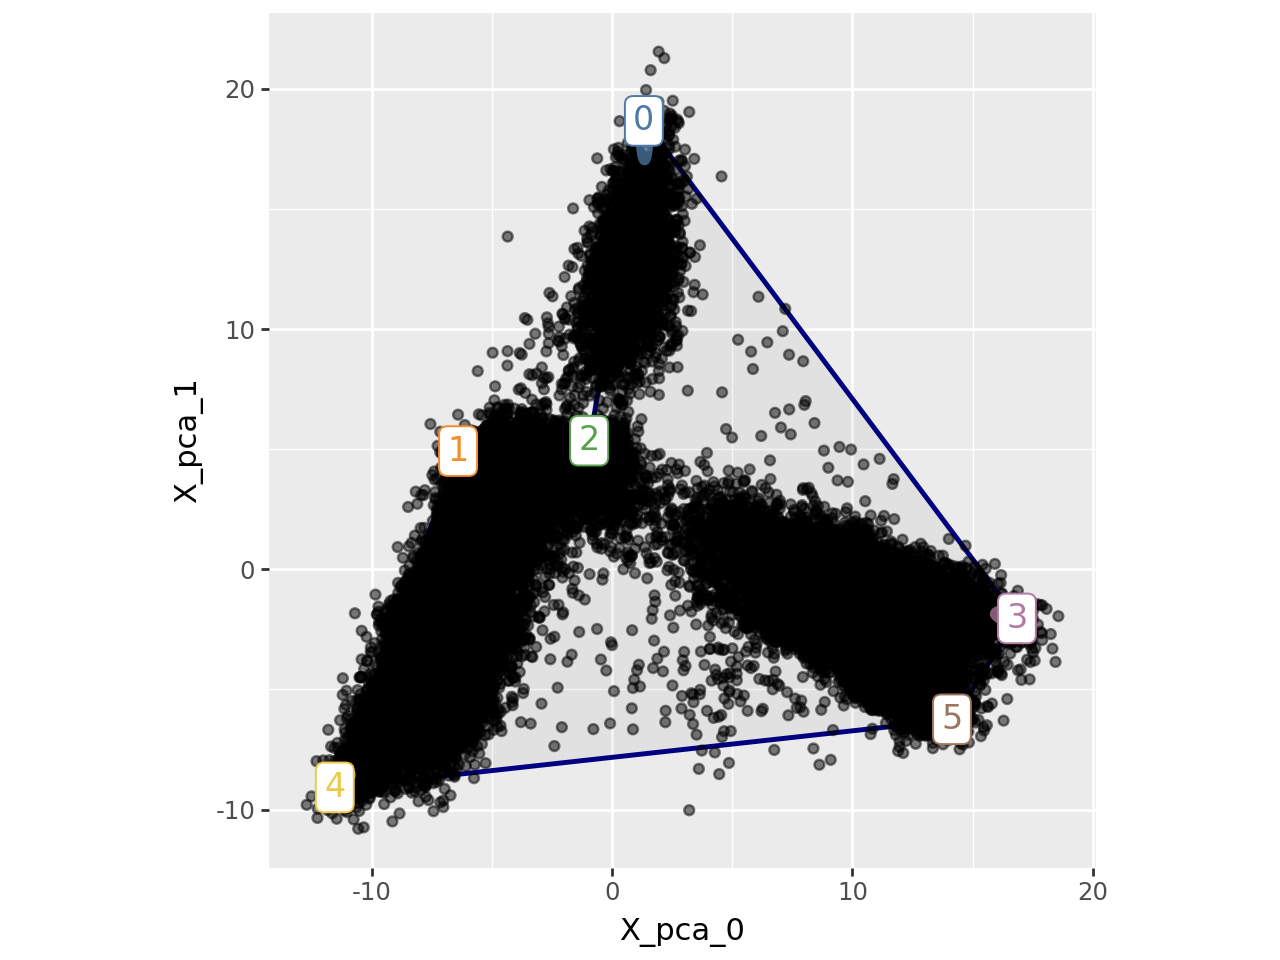

In [39]:
n_archetypes = 6

pt.plot_archetypes_2D(adata=adata_harmony, show_contours=True, result_filters={"n_archetypes": n_archetypes, "delta": 0.0})

In [40]:
significance = pt.t_ratio_significance(adata_harmony, result_filters={"n_archetypes": n_archetypes, "delta": 0.0}, n_jobs=-1)
significance

Randomizing: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


{'t_ratio_p_value': np.float64(0.0), 'rss_p_value': np.float64(0.0)}

In [41]:
arch_idx = 0

Applied length scale is 11.03.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


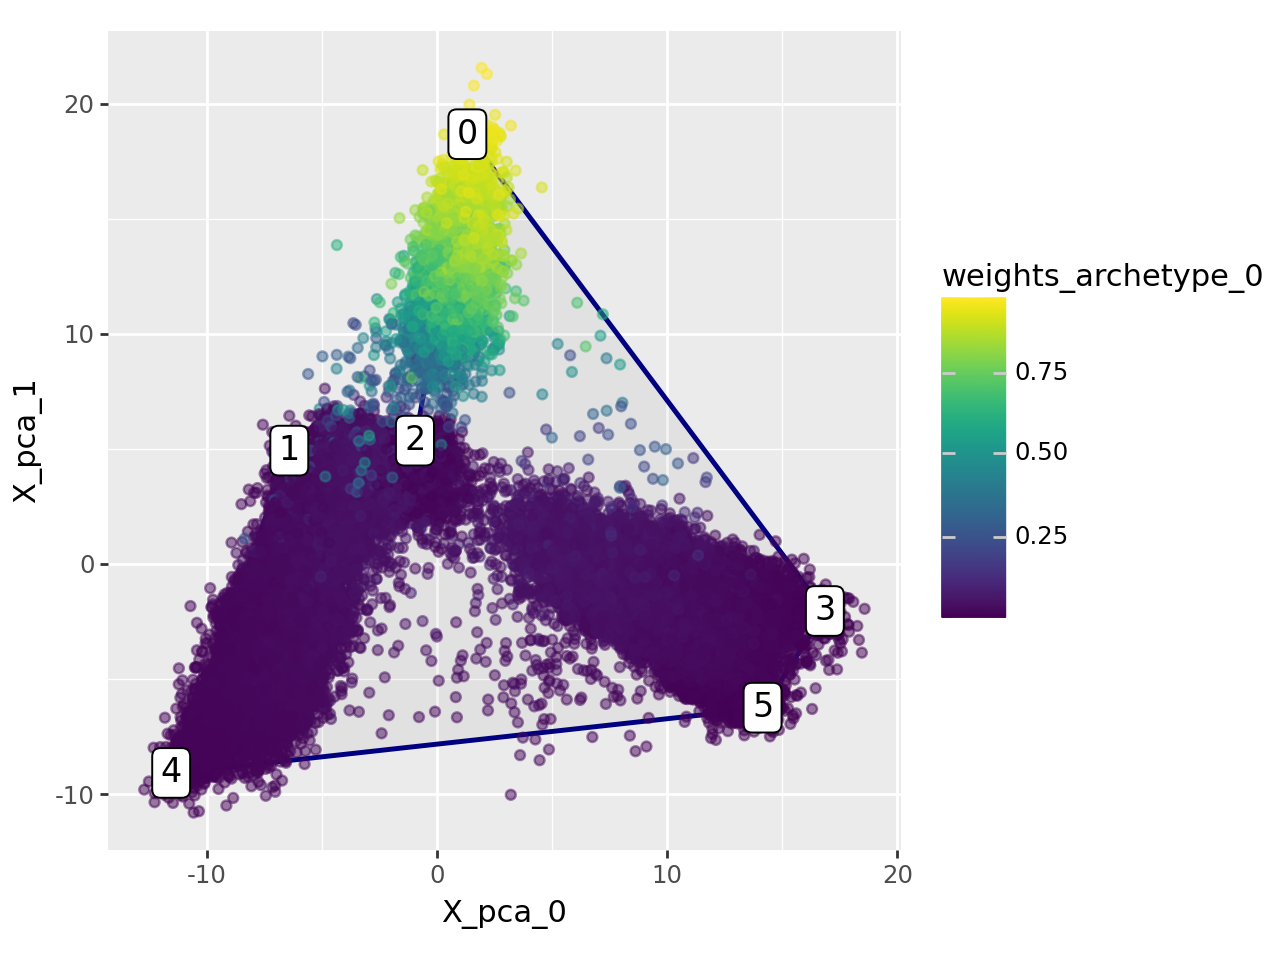

In [42]:
pt.compute_archetype_weights(adata=adata_harmony, mode="automatic", result_filters={"n_archetypes": n_archetypes, "delta": 0.0})
archetype_expression = pt.compute_archetype_expression(adata=adata_harmony, layer="z_scaled", result_filters={"n_archetypes": n_archetypes, "delta": 0.0})

adata_harmony.obs[f"weights_archetype_{arch_idx}"] = pt.get_aa_cell_weights(adata_harmony, n_archetypes=n_archetypes, delta=0.0)[:, arch_idx]
pt.plot_archetypes_2D(adata=adata_harmony, color=f"weights_archetype_{arch_idx}", result_filters={"n_archetypes": n_archetypes, "delta": 0.0})

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


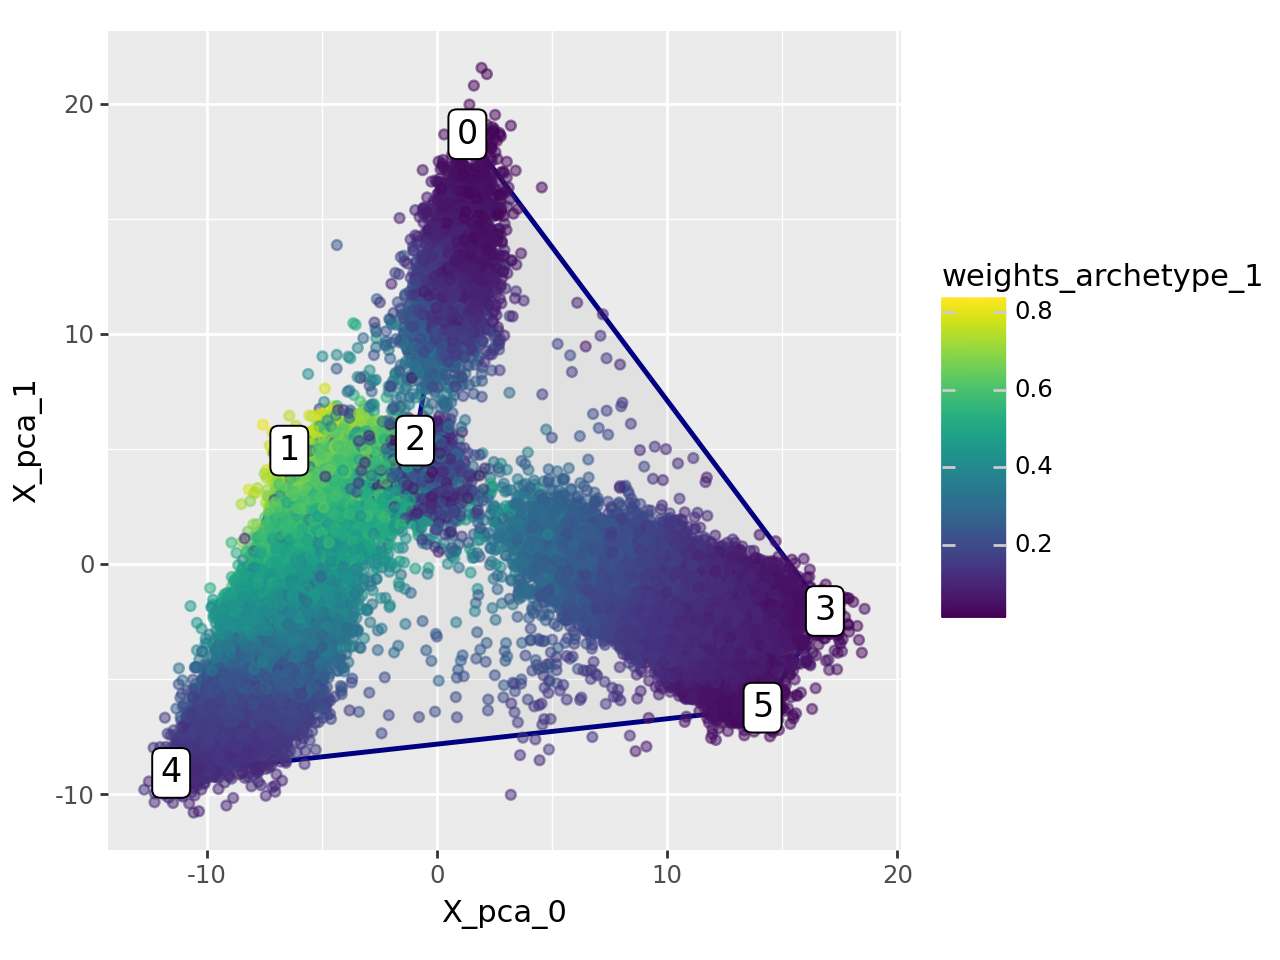

In [43]:

weights = pt.get_aa_cell_weights(adata_harmony, n_archetypes=n_archetypes, delta=0.0)

for arch_idx in range(weights.shape[1]):
    adata_harmony.obs[f"weights_archetype_{arch_idx}"] = weights[:, arch_idx]


pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="weights_archetype_1",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


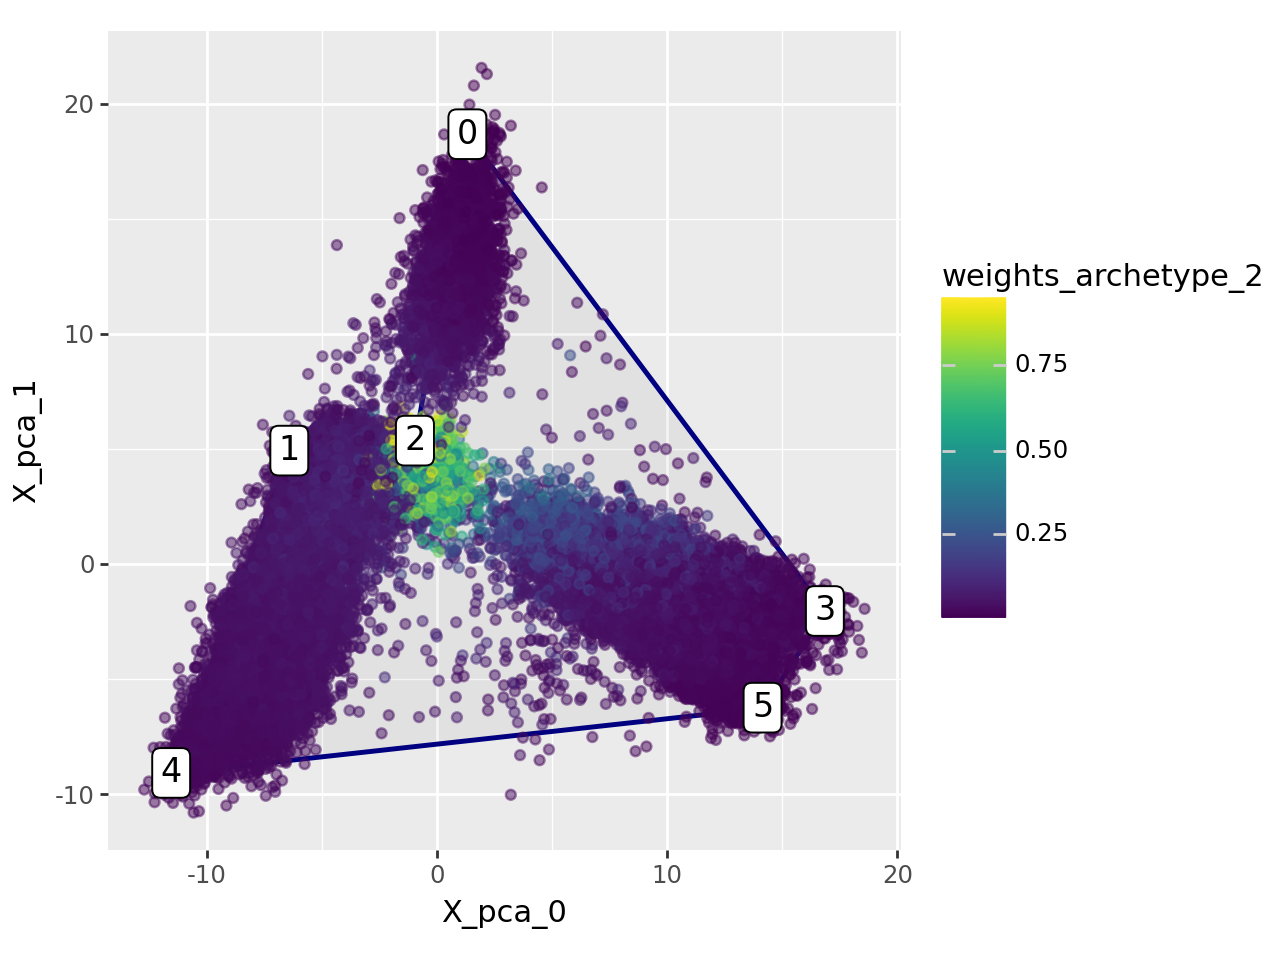

In [44]:
pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="weights_archetype_2",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


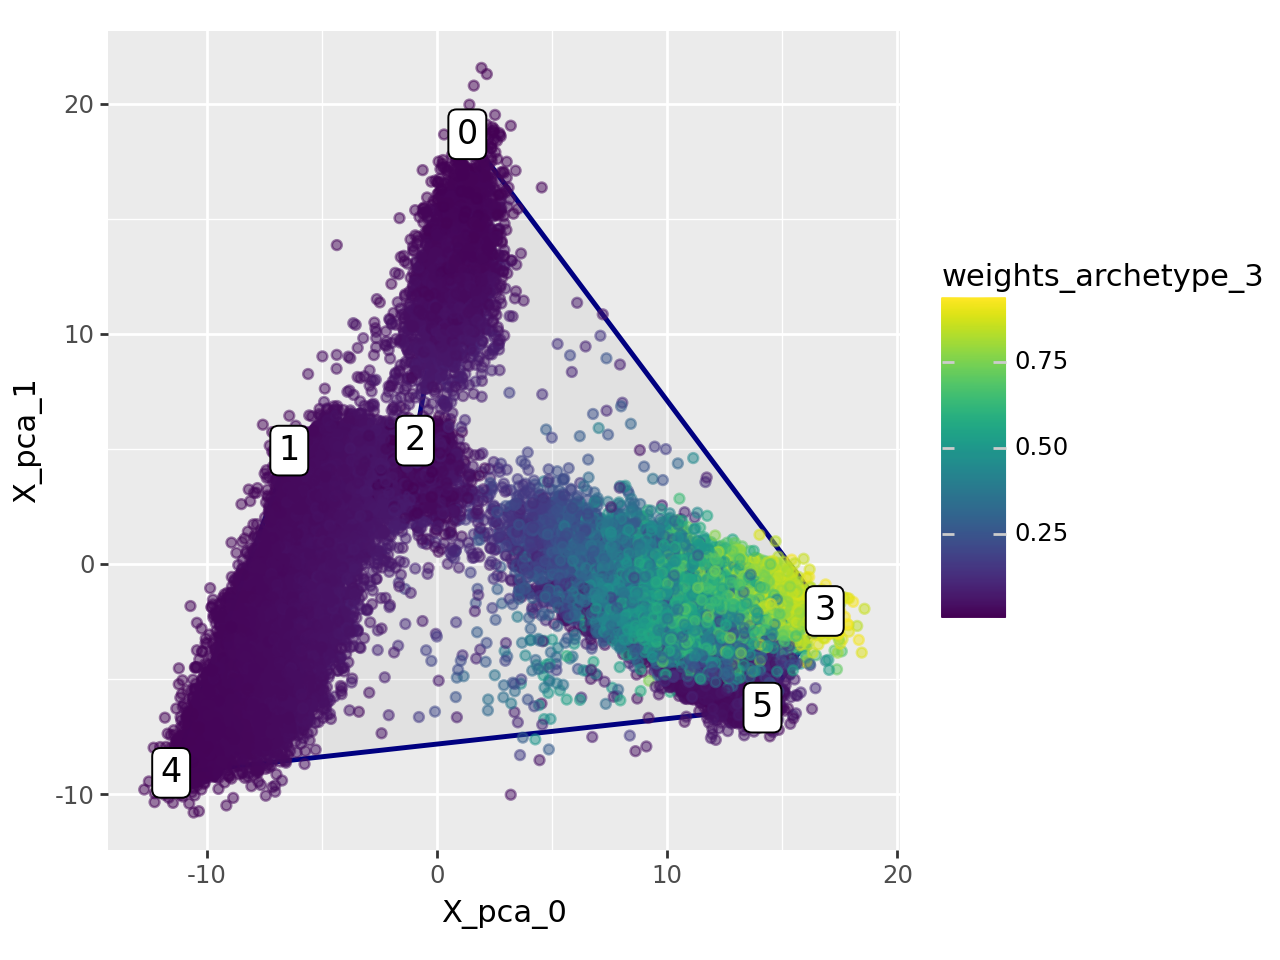

In [45]:
pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="weights_archetype_3",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


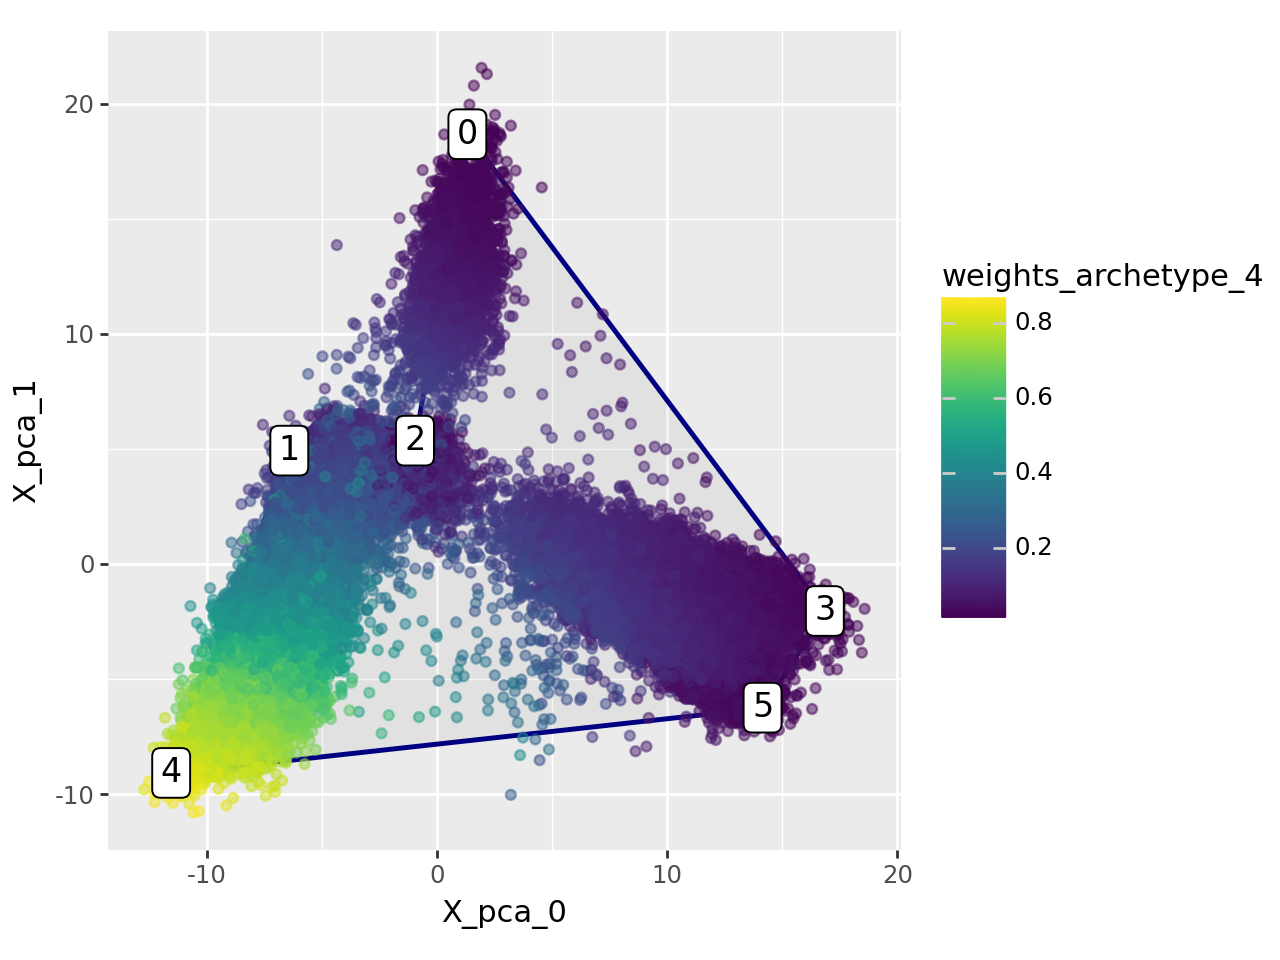

In [46]:
pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="weights_archetype_4",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


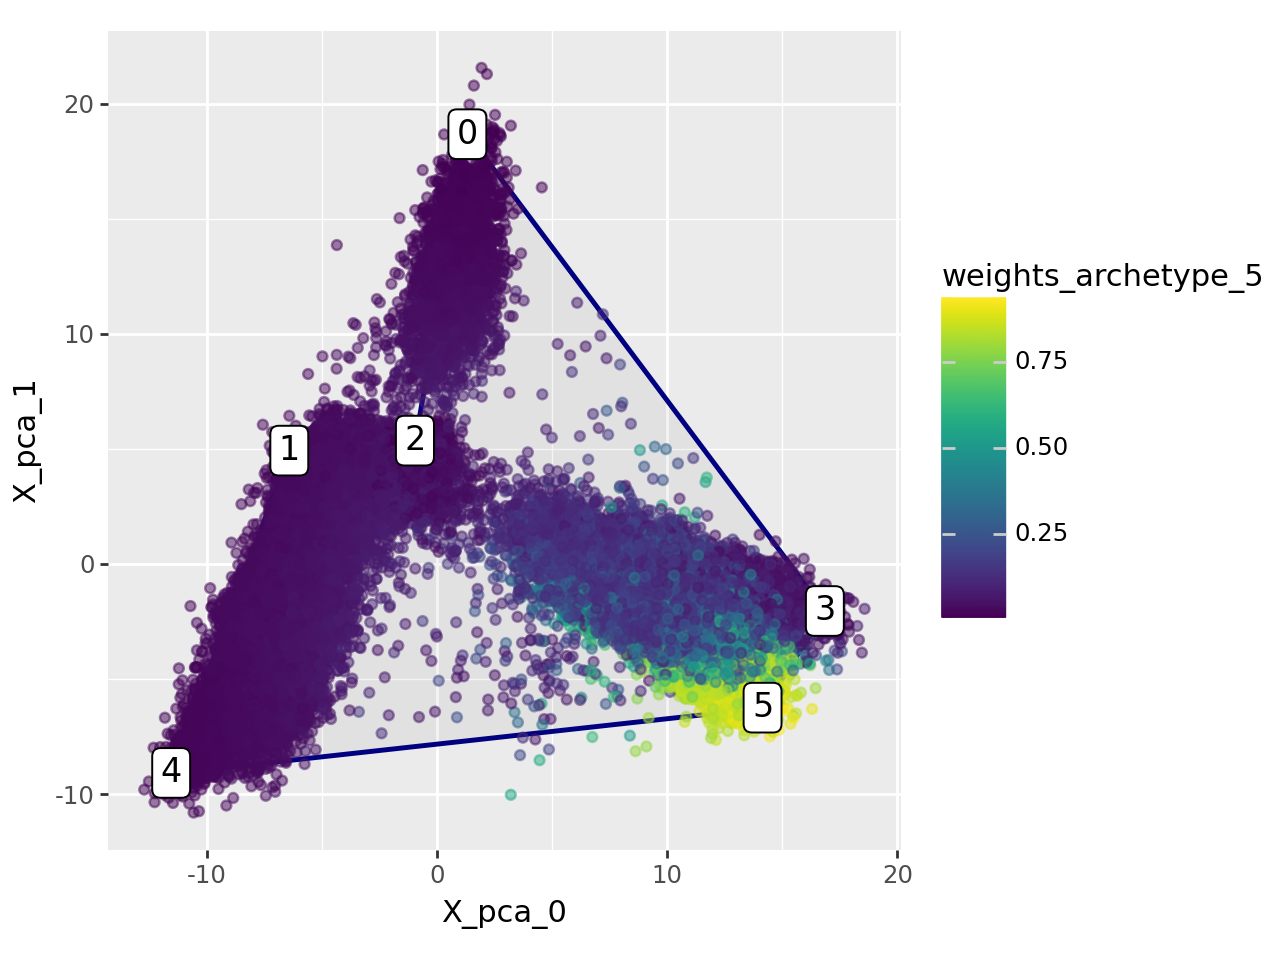

In [47]:
pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="weights_archetype_5",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)

In [49]:
from plotnine import theme, element_text, guides, guide_legend

fig = (pt.plot_archetypes_2D(
    adata=adata_harmony,
    color="cell_type",
    result_filters={"n_archetypes": n_archetypes, "delta": 0.0}
)
+ theme(
    figure_size=(20, 15),                # делаем картинку больше
    legend_position=(0.95, 0.95),        # правый верхний угол
    legend_justification=(1, 1),         # якорим легенду к углу
    legend_text=element_text(size=8),    # уменьшаем шрифт легенды
    legend_title=element_text(size=9)    # уменьшаем заголовок
)
+ guides(color=guide_legend(ncol=1))     # легенда в одну колонку
)

# Сохранение в файл
fig.save("archetypes_plot_large.png", dpi=300)



c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 20 x 15 in image.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: archetypes_plot_large.png
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


In [50]:
# допустим, в var есть 'gene_symbols'
gene_map = (
    adata_harmony.var
    .reset_index()
    .set_index("index")["gene_symbols"]
)

# удаляем пустые
gene_map = gene_map[gene_map.notna()]


# заменяем ENSG на gene symbols
archetype_expression = archetype_expression.rename(
    columns=gene_map
)

archetype_expression

SAMD11      KLHL17     PLEKHN1         HES4        ISG15      TTLL10  \
0  -94.881687 -146.846955  -94.962827    70.335060  -627.060677  -65.780304   
1 -372.338215 -307.673303    2.647739 -1461.287008 -1068.502046 -273.526572   
2  -69.684103 -115.019511  -73.747067  -294.889932  -390.445939  -65.752656   
3 -137.229914  -55.530334 -252.872834  3202.064648   655.932631 -197.362836   
4 -339.858983 -267.995499 -270.060296 -1101.788433  -221.946750 -284.838179   
5    2.395592   13.988922 -158.648222  -414.434336  1652.022786 -129.044632   

      TNFRSF18      TNFRSF4       MXRA8  RP5-832C2.5  ...        BACE2  \
0   115.103284   233.758841  -70.932281  -137.421900  ...  2770.823421   
1   882.367494  1249.491511 -305.599942    59.751353  ...  -931.328282   
2  -199.333647   -82.289541  -69.149675    25.810058  ...    30.620501   
3 -1201.293596  -704.647088   86.449970  -290.305632  ...  -551.132107   
4  1452.040847    21.524024 -371.412087   632.703252  ...  -997.522947   
5 -1048.884380  -718.610849  176.185993  -306.205909  ...  -332.693212   

      TMPRSS2         CSTB    TRAPPC10      ADARB1      COL18A1    C21orf58  \
0 -104.507235  -346.413707 -222.485154  181.366056  1545.777508 -129.824279   
1 -413.898408 -2892.085913  -17.844715  434.136089  -394.024859 -306.063437   
2 -112.585632  -766.812996  -98.826208   18.051846  -140.892083  -51.434350   
3 -157.974217  2186.100660 -239.055969 -249.308283  -296.554255 -235.843963   
4 -282.703119 -3505.015434  800.350430  -76.135939  -533.672202 -144.716910   
5   61.143287  5324.227388 -222.292608 -329.371464  -264.094280  142.108403   

         DIP2A        S100B      MT-ATP8  
0  -381.761733  -329.721759   -77.639878  
1    81.495219  -697.571824  -796.106354  
2  -210.838420    59.222065  -107.115403  
3  -936.784302  -123.345534  1208.070211  
4  2055.781511  1157.581698  -860.974466  
5  -607.892276   -66.165080   633.765887  

[6 rows x 3000 columns]

In [51]:
archetype_expression.T.sort_values(arch_idx, ascending=False).head(10)

0            1           2            3            4  \
C1QB  -873.933146 -3470.068939 -544.186241  1009.050167 -3475.302975   
APOC1 -514.731137 -3040.499076 -667.231000  -126.111056 -2956.097198   
C1QA  -913.601896 -3602.208765 -581.682458  1569.370301 -3733.637385   
C1QC  -843.077896 -3568.133548 -555.173350  1320.498845 -3553.494059   
MARCO -684.926586 -3163.543063 -774.434551   607.962339 -2952.366087   
FBP1  -554.712367 -3148.972449 -710.470508   444.892073 -2923.808780   
ACP5  -561.023986 -3021.236235 -574.652103   374.085746 -3066.861560   
CD68  -597.510585 -4450.394533 -819.012209  3478.747197 -4431.622091   
VSIG4 -821.704593 -3374.812652 -598.342528  1437.893672 -3358.137209   
GPNMB -533.795252 -2781.668745 -642.687658   187.214223 -2778.519074   

                 5  
C1QB   7354.441130  
APOC1  7304.669466  
C1QA   7261.760198  
C1QC   7199.380003  
MARCO  6967.307942  
FBP1   6893.072027  
ACP5   6849.688140  
CD68   6819.792217  
VSIG4  6715.103302  
GPNMB  6549.456504

In [52]:
import decoupler as dc

database = "reactome_pathways"

min_genes_per_pathway = 5
max_genes_per_pathway = 80

msigdb_raw = dc.op.resource("MSigDB")


In [53]:
msigdb = msigdb_raw.loc[
    msigdb_raw["collection"] == database
].copy()


In [54]:
selection_vec = (
    ~msigdb["geneset"].str.contains("RESPONSE_TO", regex=False) &
    ~msigdb["geneset"].str.contains("GENE_EXPRESSION", regex=False) &
    ~msigdb["geneset"].str.contains("SARS_COV", regex=False) &
    ~msigdb["geneset"].str.contains("STIMULATED_TRANSCRIPTION", regex=False)
)

msigdb = msigdb.loc[selection_vec].copy()


In [55]:
msigdb = msigdb.drop_duplicates(
    subset=["geneset", "genesymbol"]
)

geneset_sizes = msigdb.value_counts("geneset")

genesets_to_keep = geneset_sizes[
    (geneset_sizes >= min_genes_per_pathway) &
    (geneset_sizes <= max_genes_per_pathway)
].index.tolist()

msigdb = msigdb.loc[
    msigdb["geneset"].isin(genesets_to_keep)
].copy()


In [56]:
msigdb = msigdb.rename(
    columns={
        "geneset": "source",
        "genesymbol": "target"
    }
)

In [57]:
organism = adata_harmony.uns.get("organism", "human").lower()

msigdb_net = msigdb.copy()

common_genes = archetype_expression.columns.intersection(
    msigdb_net["target"]
)

archetype_expression = archetype_expression.loc[:, common_genes]
msigdb_net = msigdb_net.loc[
    msigdb_net["target"].isin(common_genes)
]


In [58]:
acts_ulm_est, acts_ulm_pvals = dc.mt.ulm(
    data=archetype_expression,
    net=msigdb_net,
    verbose=False
)
acts_ulm_est.iloc[:4, :4]


REACTOME_ACTIVATION_OF_KAINATE_RECEPTORS_UPON_GLUTAMATE_BINDING  \
0                                          -0.318551                 
1                                           0.793491                 
2                                           0.757456                 
3                                          -1.009088                 

   REACTOME_ACTIVATION_OF_MATRIX_METALLOPROTEINASES  \
0                                          4.059872   
1                                         -1.749843   
2                                         -1.440216   
3                                          1.257246   

   REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS  \
0                                          2.530197   
1                                          0.386577   
2                                         -1.742873   
3                                          0.178152   

   REACTOME_ATTENUATION_PHASE  
0                    3.102461  
1                    0.731693  
2                   -0.543393  
3                    1.821541

In [59]:
top_processes = pt.extract_enriched_processes(
    est=acts_ulm_est,
    pval=acts_ulm_pvals,
    order="desc",
    n=10,
    p_threshold=0.05
)



In [60]:
import plotnine as pn
def plot_archetype_processes(
    df: pd.DataFrame,
    arch_idx: int,
    figsize=(10, 3)
):
    """
    df       : DataFrame из top_processes[arch_idx]
    arch_idx : индекс архетипа
    """

    value_col = str(arch_idx)

    # сортировка для корректного порядка столбцов
    df = df.sort_values(value_col, ascending=True).copy()

    # фиксируем порядок категорий
    df["Process"] = pd.Categorical(
        df["Process"],
        categories=df["Process"].tolist(),
        ordered=True
    )

    p = (
        pn.ggplot(df)
        + pn.geom_col(pn.aes(x="Process", y=value_col), fill="#4C72B0")
        + pn.coord_flip()
        + pn.labs(
            title=f"Archetype {arch_idx}: enriched processes",
            x="Process",
            y="ULM activity"
        )
        + pn.theme(
            figure_size=figsize,
            axis_text_y=pn.element_text(size=8),
            axis_title=pn.element_text(size=10),
            plot_title=pn.element_text(size=11, weight="bold")
        )
    )

    return p


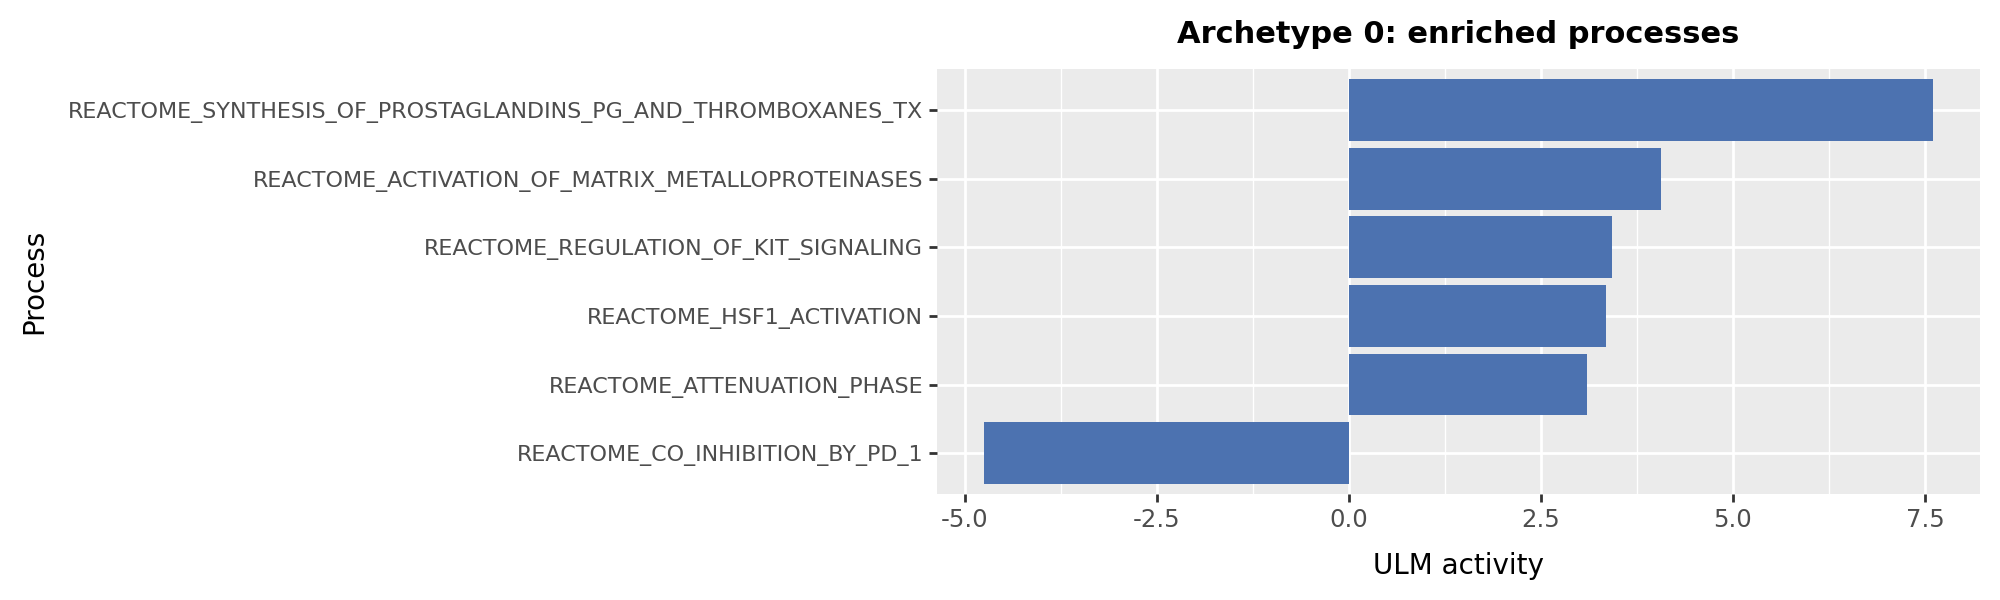

In [61]:
plots = {}
n_archetypes = 6

for arch_idx in range(n_archetypes):
    if arch_idx not in top_processes:
        print(f"Archetype {arch_idx}: no significant processes")
        continue

    plots[arch_idx] = plot_archetype_processes(
        top_processes[arch_idx],
        arch_idx
    )
plots[0]


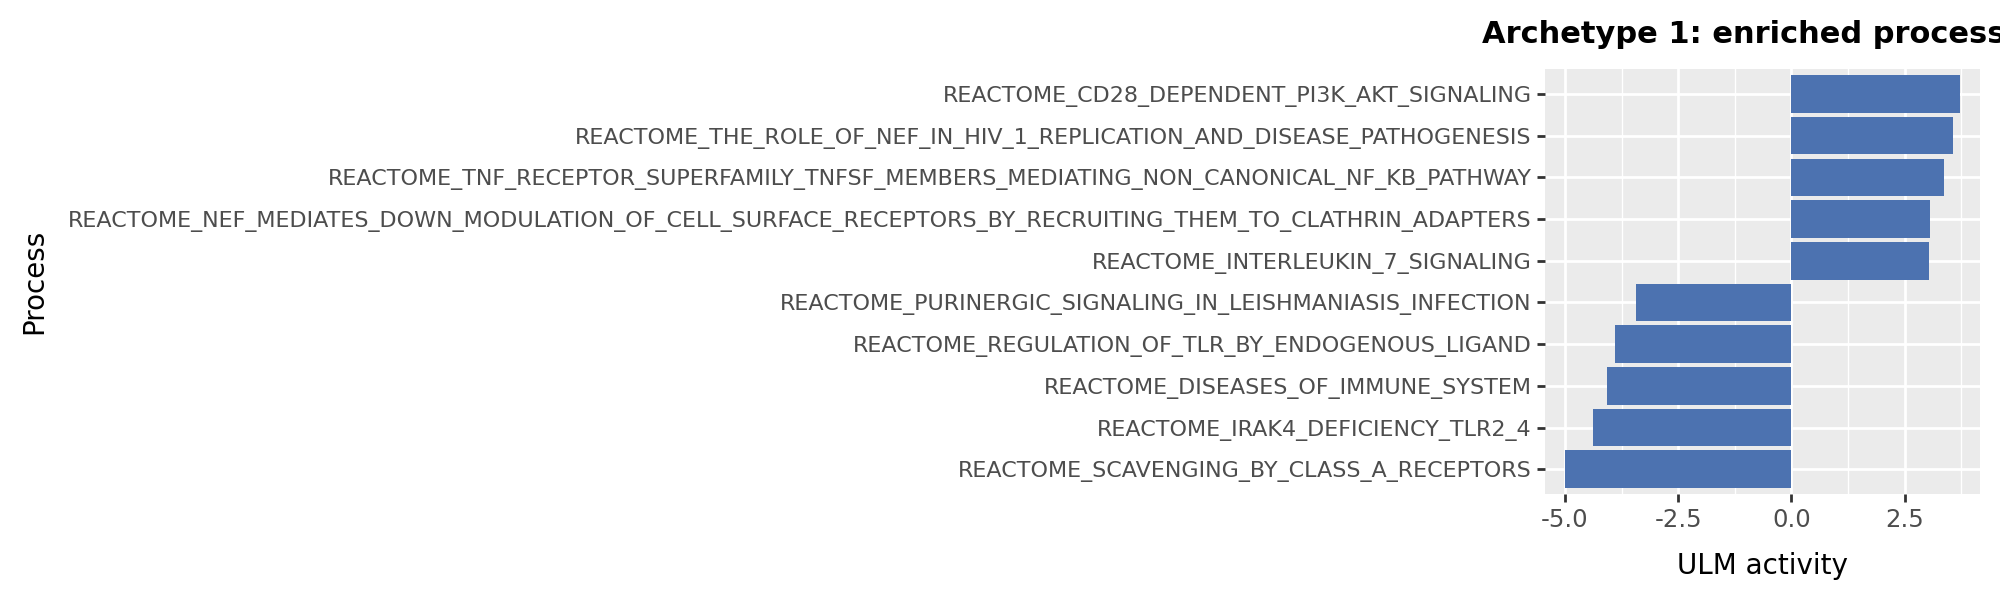

In [62]:
plots[1]

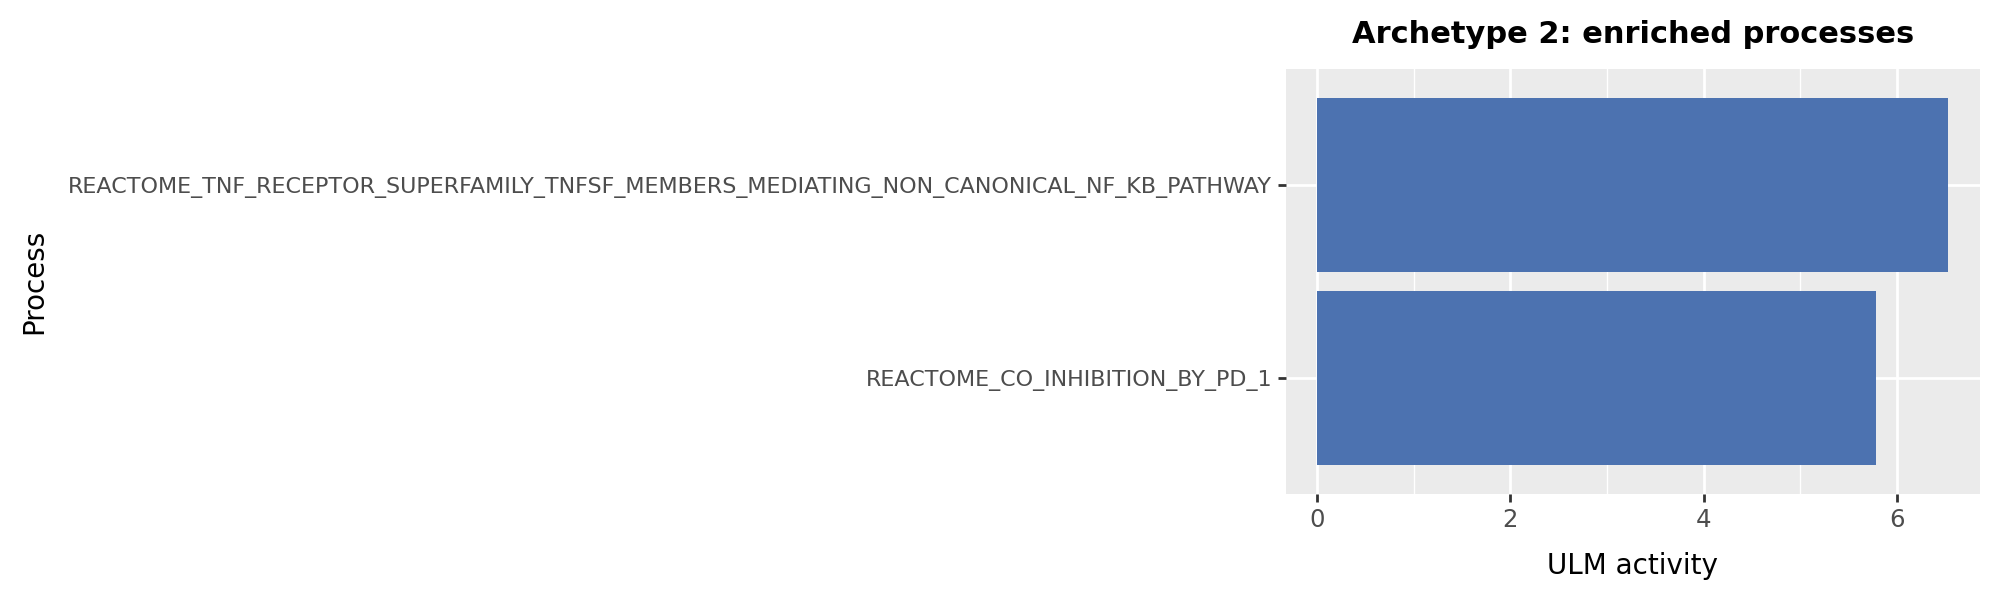

In [63]:
plots[2]

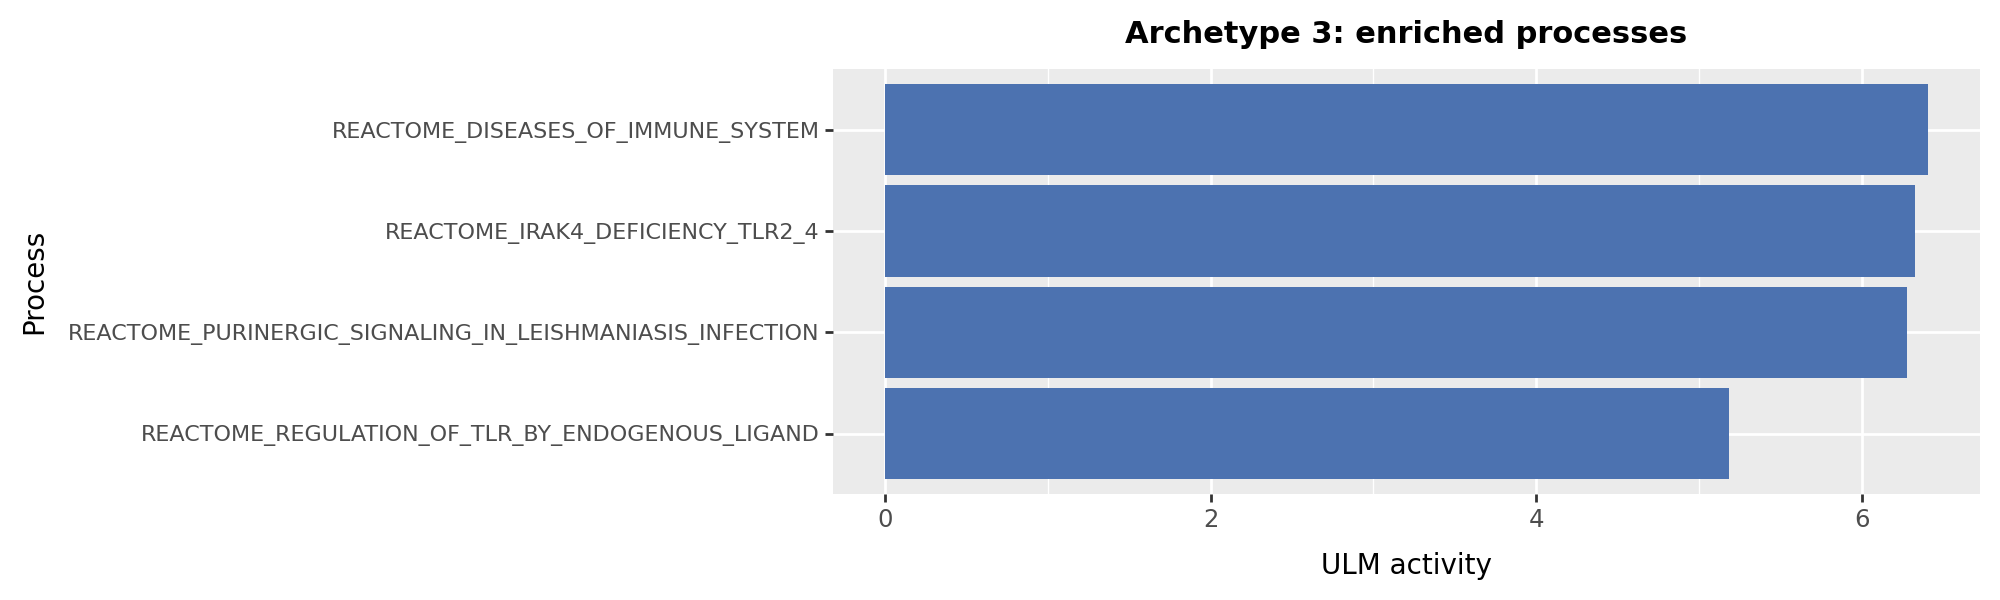

In [64]:
plots[3]

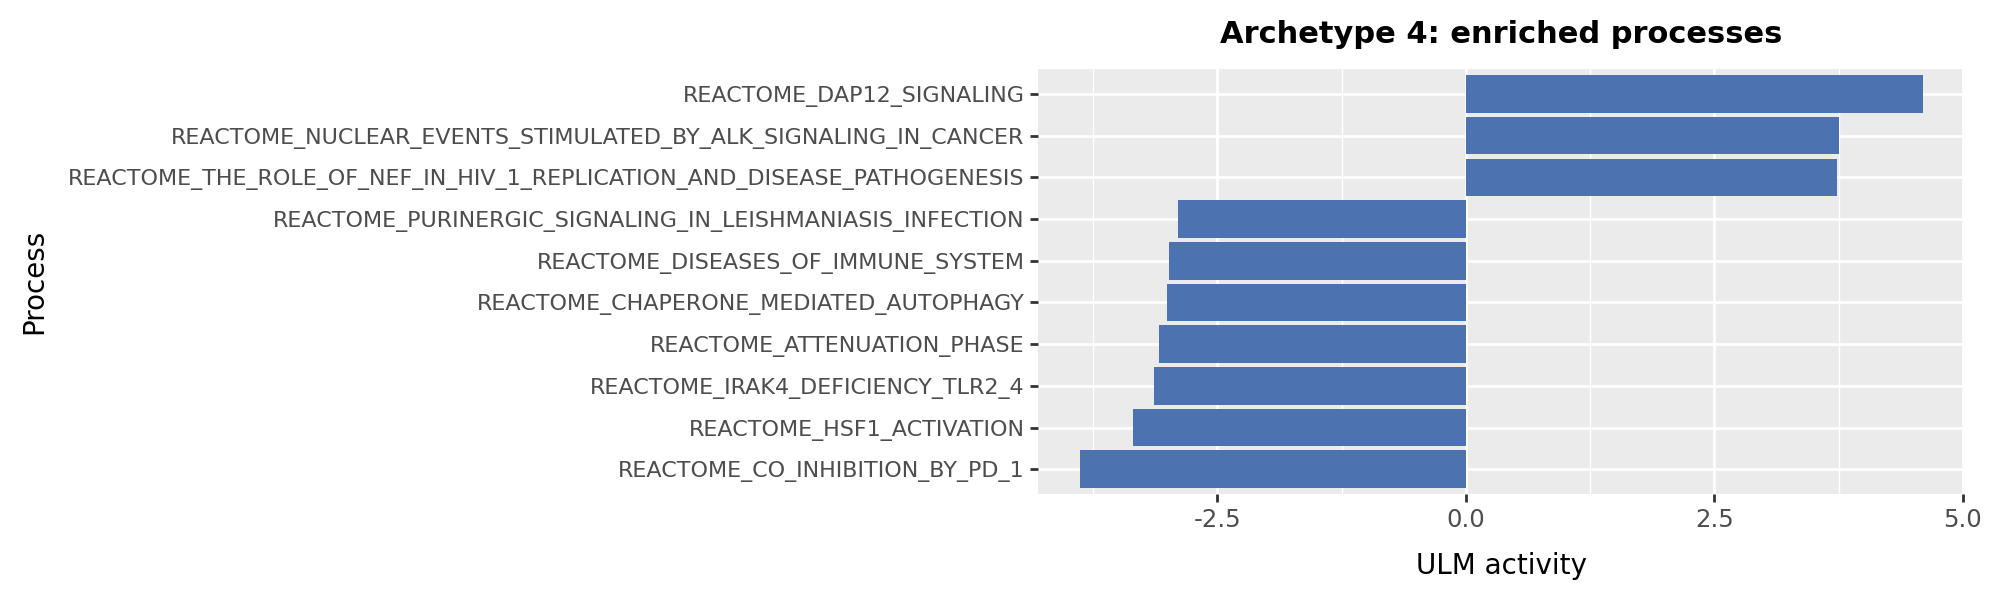

In [65]:
plots[4]

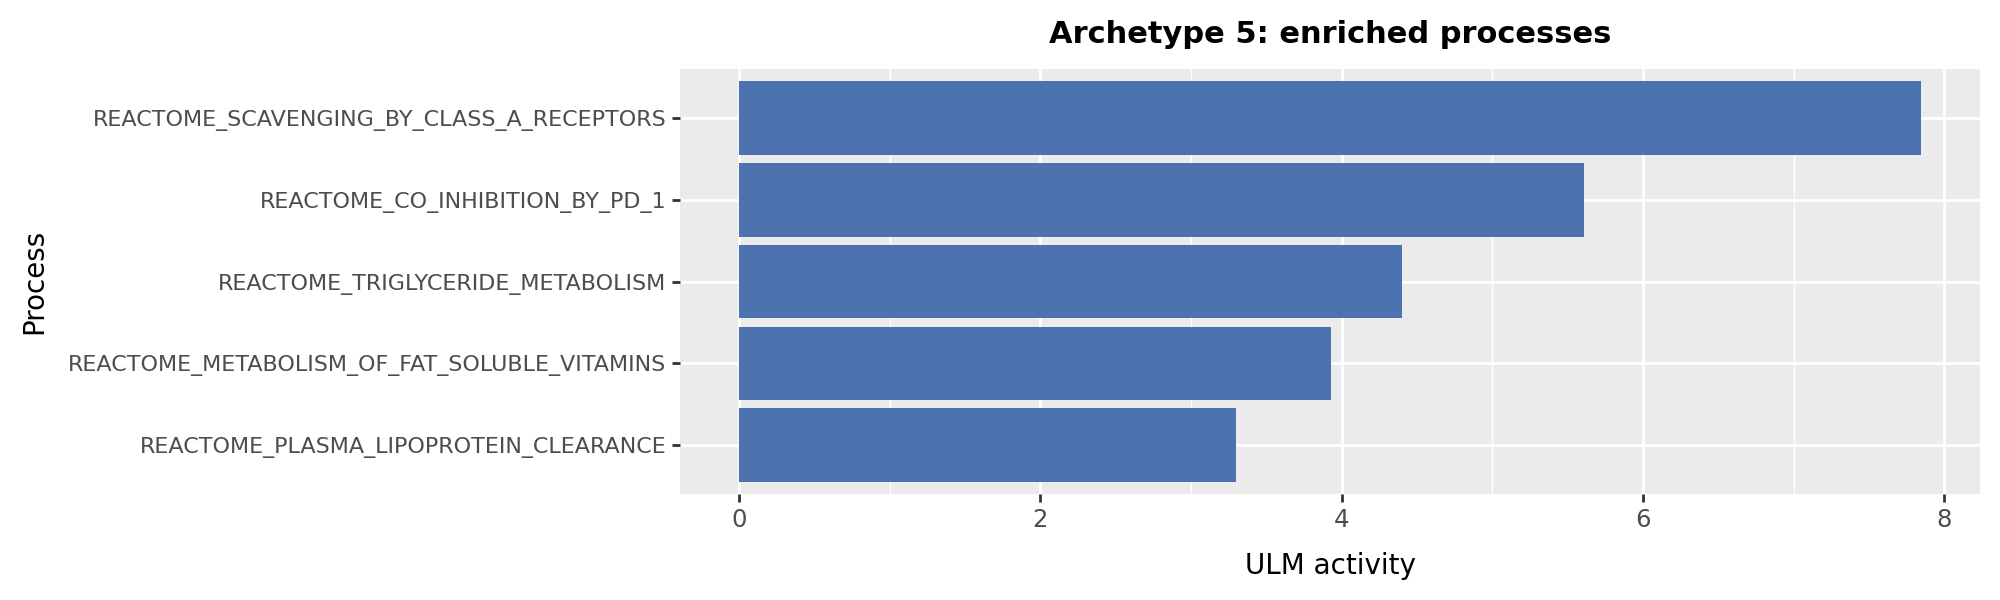

In [66]:
plots[5]

In [67]:
def get_top_genes(
    archetype_expression,
    arch_idx: int,
    n: int = 10,
    direction: str = "positive"  # "positive", "negative", "absolute"
):
    """
    Возвращает top-n генов для архетипа
    """

    s = archetype_expression.loc[arch_idx]

    if direction == "positive":
        s = s.sort_values(ascending=False)
    elif direction == "negative":
        s = s.sort_values(ascending=True)
    elif direction == "absolute":
        s = s.reindex(s.abs().sort_values(ascending=False).index)
    else:
        raise ValueError("direction must be positive / negative / absolute")

    df = (
        s.head(n)
        .reset_index()
        .rename(columns={"index": "Gene", arch_idx: "Contribution"})
    )

    return df


In [68]:
def plot_top_genes(
    df: pd.DataFrame,
    arch_idx: int,
    direction: str,
    figsize=(6, 3)
):
    df = df.sort_values("Contribution", ascending=True)

    df["Gene"] = pd.Categorical(
        df["Gene"],
        categories=df["Gene"].tolist(),
        ordered=True
    )

    p = (
        pn.ggplot(df)
        + pn.geom_col(
            pn.aes(x="Gene", y="Contribution"),
            fill="#4C72B0"
        )
        + pn.coord_flip()
        + pn.labs(
            title=f"Archetype {arch_idx}: top genes ({direction})",
            x="Gene",
            y="Archetype loading"
        )
        + pn.theme(
            figure_size=figsize,
            axis_text_y=pn.element_text(size=8),
            plot_title=pn.element_text(weight="bold")
        )
    )

    return p


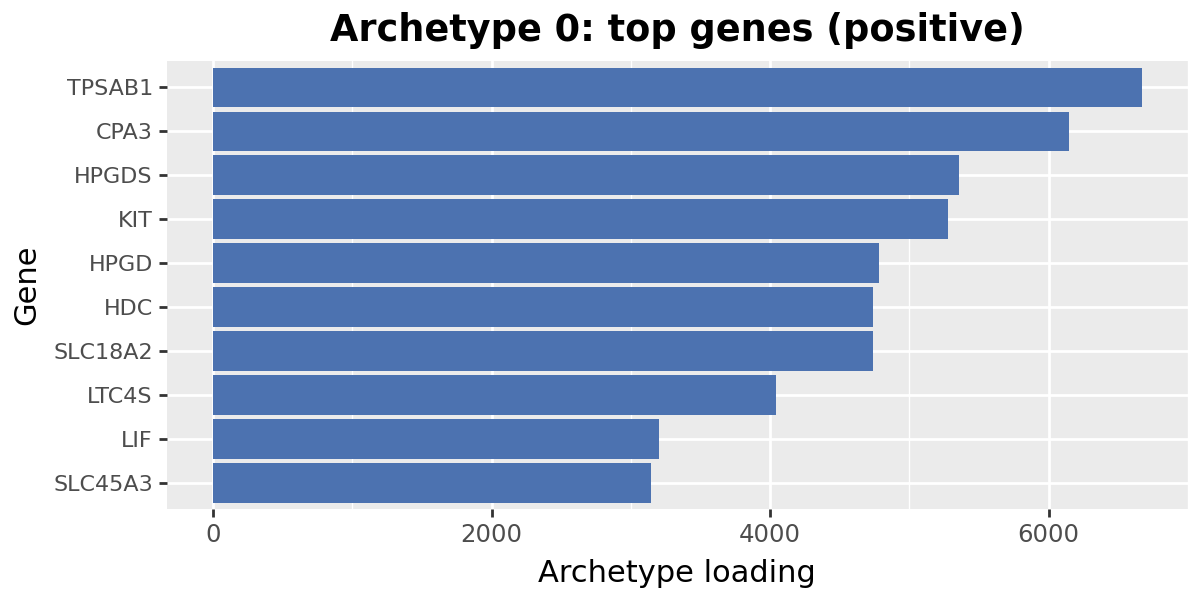

In [69]:
gene_plots = {}

for arch_idx in range(6):
    df = get_top_genes(
        archetype_expression,
        arch_idx=arch_idx,
        n=10,
        direction="positive"
    )

    gene_plots[arch_idx] = plot_top_genes(
        df,
        arch_idx,
        direction="positive"
    )
gene_plots[0]

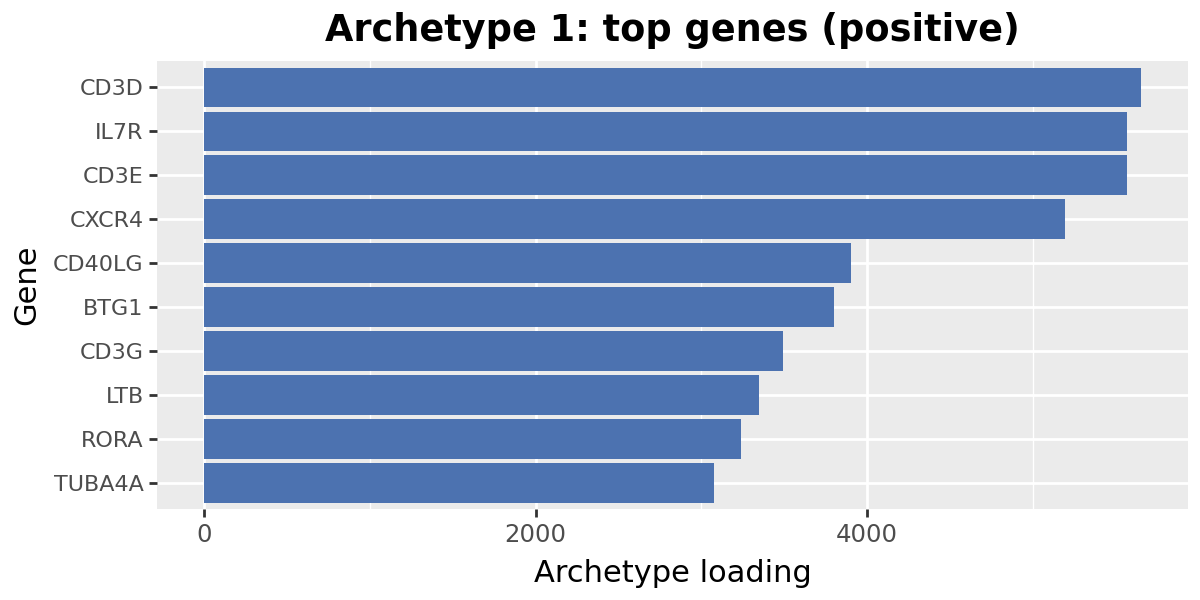

In [70]:
gene_plots[1]

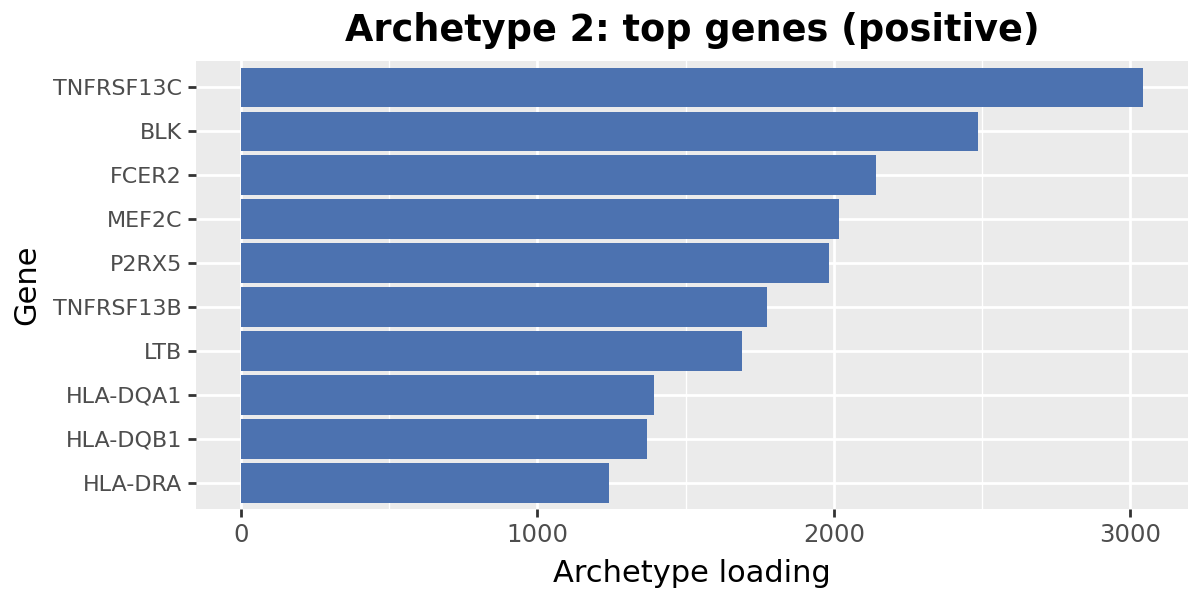

In [71]:
gene_plots[2]

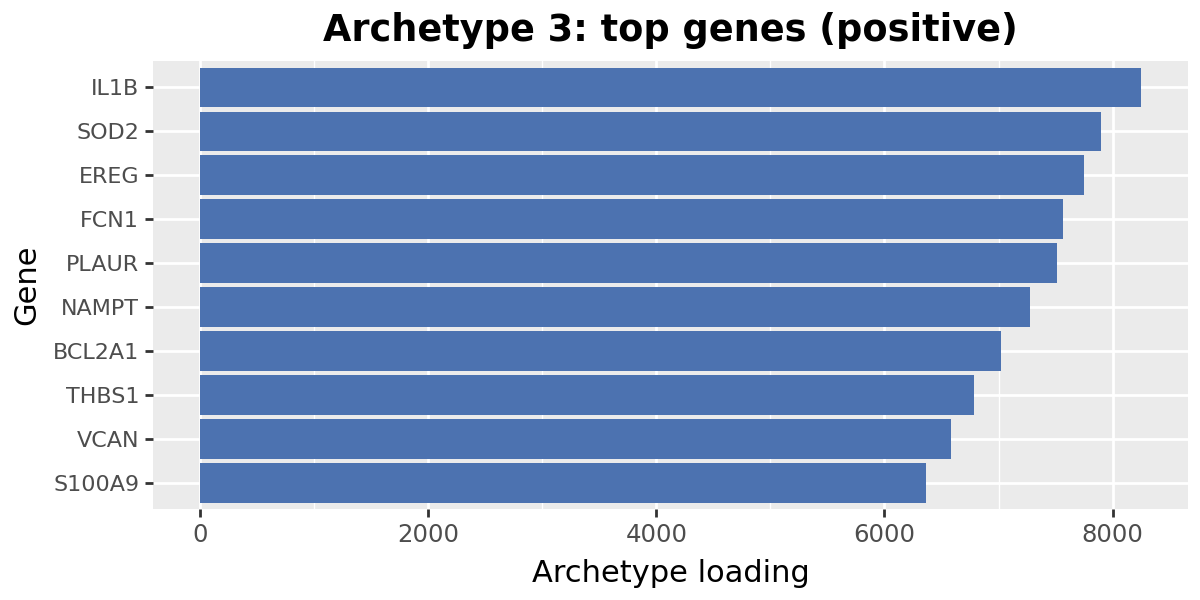

In [72]:
gene_plots[3]

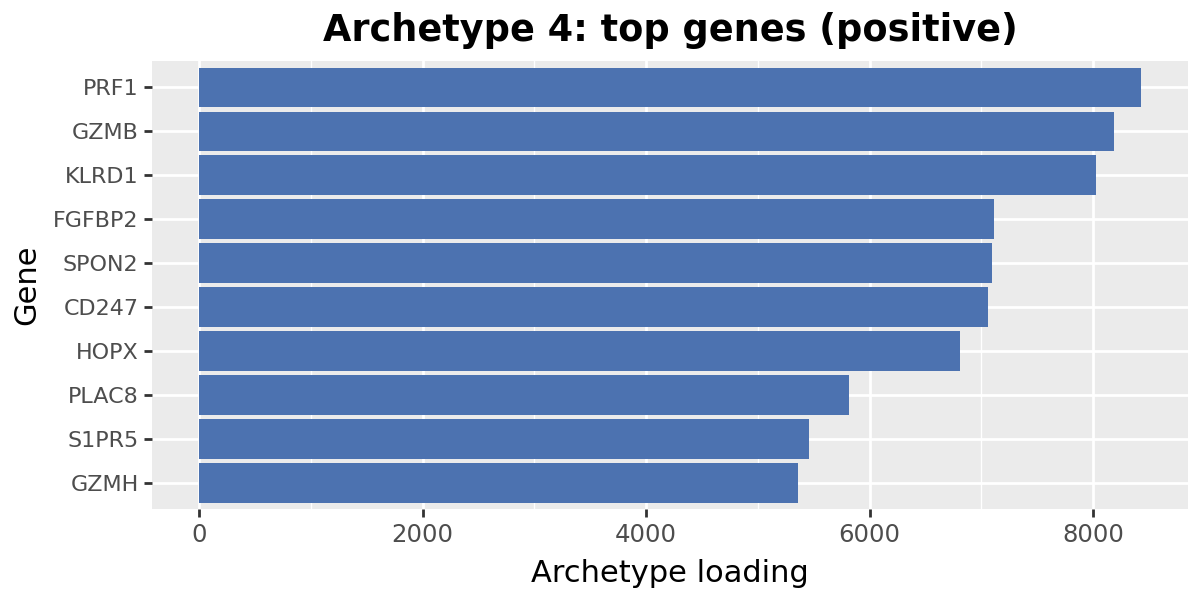

In [73]:
gene_plots[4]

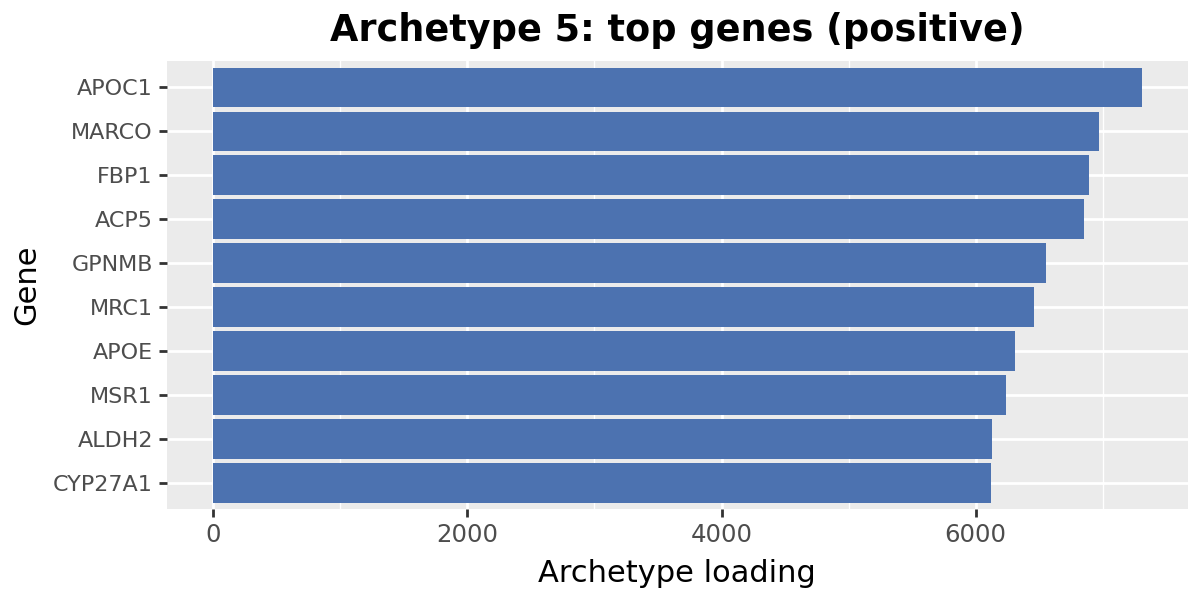

In [74]:
gene_plots[5]

Оценка кластеризации

In [75]:
W = pt.get_aa_cell_weights( adata_harmony, n_archetypes=n_archetypes, delta=0.0 ) # Присваиваем каждой клетке кластер по максимальному весу 
adata_harmony.obs["archetype_cluster"] = np.argmax(W, axis=1).astype(str)
adata_harmony.obs["archetype_cluster"]

AAACGGGCAGTCGATT-1-HCATisStab7509734    5
AAACGGGGTGAGTGAC-1-HCATisStab7509734    5
AAACGGGTCACGACTA-1-HCATisStab7509734    2
AAAGATGAGTTGAGAT-1-HCATisStab7509734    4
AAAGATGGTAGCGTGA-1-HCATisStab7509734    4
                                       ..
TTTGTCACATAGAAAC-1-HCATisStab7747200    1
TTTGTCAGTCGGATCC-1-HCATisStab7747200    4
TTTGTCATCAAACAAG-1-HCATisStab7747200    3
TTTGTCATCATGGTCA-1-HCATisStab7747200    1
TTTGTCATCTTCTGGC-1-HCATisStab7747200    3
Name: archetype_cluster, Length: 42422, dtype: object

In [83]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

# Кластеры и истинные метки
labels_true = adata_harmony.obs["cell_type"].astype(str)
labels_pred = adata_harmony.obs["leiden"].astype(str)

# ARI и NMI
ari = adjusted_rand_score(labels_true, labels_pred)
nmi = normalized_mutual_info_score(labels_true, labels_pred)

# Accuracy через оптимальное сопоставление
# строим матрицу совпадений
contingency = pd.crosstab(labels_true, labels_pred)
row_ind, col_ind = linear_sum_assignment(-contingency.values)
acc = contingency.values[row_ind, col_ind].sum() / contingency.values.sum()

print("Leiden vs True:")
print("ARI:", ari)
print("NMI:", nmi)
print("Accuracy:", acc)


Leiden vs True:
ARI: 0.4682051835369918
NMI: 0.6853332172279172
Accuracy: 0.5440809014190751


In [76]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import pandas as pd

labels_true = adata_harmony.obs["cell_type"].astype(str)
labels_pred = adata_harmony.obs["archetype_cluster"].astype(str)

# ARI и NMI
ari = adjusted_rand_score(labels_true, labels_pred)
nmi = normalized_mutual_info_score(labels_true, labels_pred)

# Accuracy через оптимальное сопоставление
contingency = pd.crosstab(labels_true, labels_pred)
row_ind, col_ind = linear_sum_assignment(-contingency.values)
acc = contingency.values[row_ind, col_ind].sum() / contingency.values.sum()

print("ParTIpy vs True:")
print("ARI:", ari)
print("NMI:", nmi)
print("Accuracy:", acc)


ParTIpy vs True:
ARI: 0.5818714065285889
NMI: 0.6898455065244535
Accuracy: 0.7360096176512188


In [77]:
labels_leiden = adata_harmony.obs["leiden"].astype(str)
labels_arche = adata_harmony.obs["archetype_cluster"].astype(str)

ari = adjusted_rand_score(labels_leiden, labels_arche)
nmi = normalized_mutual_info_score(labels_leiden, labels_arche)

contingency = pd.crosstab(labels_leiden, labels_arche)
row_ind, col_ind = linear_sum_assignment(-contingency.values)
acc = contingency.values[row_ind, col_ind].sum() / contingency.values.sum()

print("ParTIpy vs Leiden:")
print("ARI:", ari)
print("NMI:", nmi)
print("Accuracy:", acc)


ParTIpy vs Leiden:
ARI: 0.35351755008246877
NMI: 0.6119358494683411
Accuracy: 0.43967752581207864


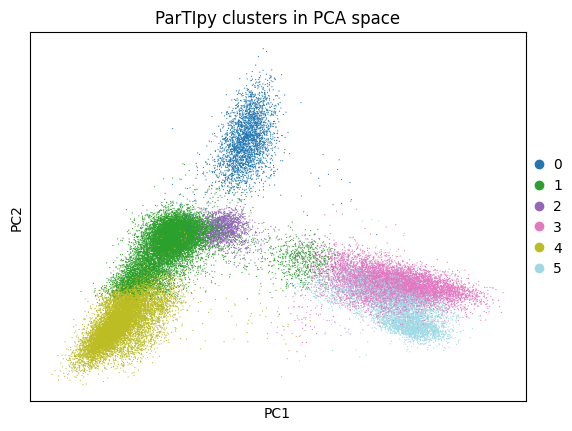

In [87]:
sc.pl.pca(
    adata_harmony,
    color="archetype_cluster",
    palette="tab20",
    title="ParTIpy clusters in PCA space"
)


... storing 'archetype_cluster' as categorical


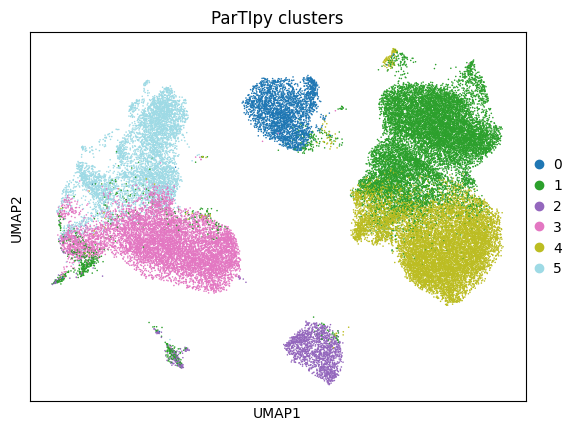

In [78]:
sc.pl.umap( adata_harmony, color="archetype_cluster", palette="tab20", size=5, title="ParTIpy clusters" )

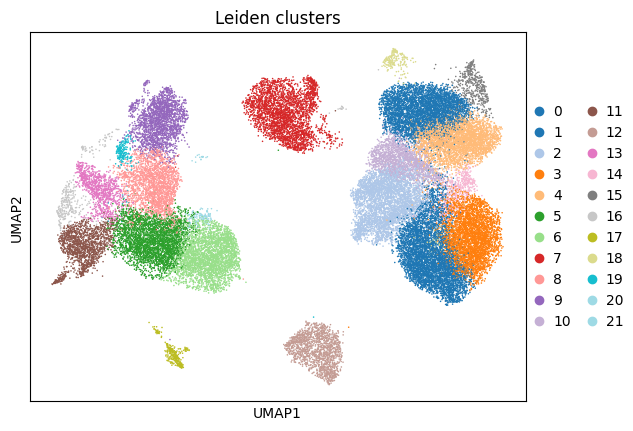

In [80]:
sc.pl.umap(
    adata_harmony,
    color="leiden",
    palette="tab20",
    size=5,
    title="Leiden clusters"
)


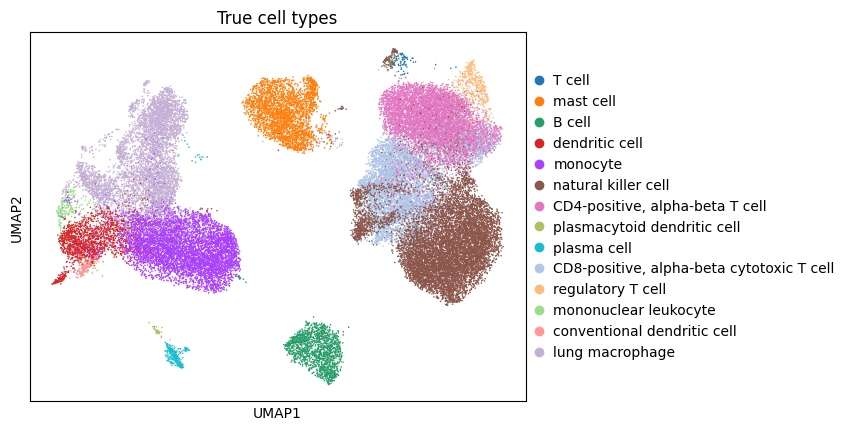

In [79]:
sc.pl.umap( adata_harmony, color="cell_type", size=5, title="True cell types" )